# Goal

**Create a sample of geocode traffic for maps analytics team.**

In [40]:
# Import Libraries and modules

import pandas as pd
import plotly.express as px
from ast import literal_eval
from scipy import stats as st
import random
%load_ext Kqlmagic
template = 'plotly_dark'
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
%matplotlib inline

The Kqlmagic extension is already loaded. To reload it, use:
  %reload_ext Kqlmagic


In [7]:
%kql AzureDataExplorer://tenant="tomtom.com";code;cluster='apianalyticsdashboard.westeurope';database='ttapianalytics-westeu-db'

/Users/bakhtiar/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


<IPython.core.display.Javascript object>

# Getting total number of transactions per customer

In [8]:
# Set parameters for the sampling
nbr_days = '30'  # Date range for taking the sample
top_nbr_clients = '20'  # Take sample of queries for only 20 top clients

In [9]:
# Run a query to get number of queries per client (top 20) over the last 30 days.
q = '''
ApiCallDetails
| where client_sent_start_timestamp between (now(-'''+nbr_days+'''d)..now(0d))
| where message_status_code == '200'
| where method_name=="search 2 geocode"
| where request_path != '/geocode/1555%20Blake%20Street%2080202.json'
| where developer_email != 'andrea.stucchi@tomtom.com'
| where not (request_uri contains "typeahead=true")
| project developer_email
| summarize count() by developer_email
| as T
| extend percentage = round(100.0 * count_ / toscalar(T | summarize sum(count_)), 2)
| sort by percentage
| take '''+top_nbr_clients+'''
'''
%kql res << -query q
df_traffic_per_client = res.to_dataframe() 

In [10]:
df_traffic_per_client

,developer_email,count_,percentage
0,data_products@alteryx.com,21780399,38.90
1,VZ.NBI.VLT.ClassicPartner@verizon.com,18417718,32.89
2,developers@prima.it,1691826,3.02
3,tttAPI-KEY-MGMT@groups.webfleet.com,1588471,2.84
4,christopher.witt@gm.com,1081468,1.93
5,luke@postcodeanywhere.co.uk,907643,1.62
6,brian.riordan@tomtom.com,762701,1.36
7,Comm@apb.be,727399,1.30
8,mapreciado@homeria.com,513842,0.92
9,gabriel.romero@tomtom.com,473643,0.85


Description of dataframe:

- `developer_email` : customer name/email
- `count_` : total number of queries per customer
- `percetage`: percentage of queries per customer 

# Determining sample size 

## Slovin's formula

If you take a population sample, you must use a formula to figure out what sample size you need to take. If you know nothing about your population at all, we can use **Slovin’s formula** to figure out what sample size you need to take, which is written as

$$n = \frac{N}{(1 + N*e^{2})}$$

Where:

- $n$ = Number of samples,
- $N$ = Total population and
- $e$ = Error tolerance (level).

## Cochran's formula

In the case of a population of infinite size, a sample size formula like Cochran's can be used to find out how many samples are needed to create a representative sample. The Cochran formula is:

$$n_{0} = \frac{Z^{2}pq}{e^{2}}$$

where 
- $n_{0}$ is the sample size
- $Z$ is the Z-value for a given confidence level (looked up in a Z-table)
- $p$ is the estimated proportion of an attribute that is present in the population (assume 0.5 (maximum variability) when uncertain)
- $q$ is $1-p$
- $e$ is the desired level of precision


Thus, in case of a $95\%$ confidence level and a $2\%$ margin of error, with maximum variability, the sample size would be: 
$$n_0 = (1.67)^2*0.5*0.5 / (0.02)^2 = 2401$$
A few more examples:

In case of a $95\%$ confidence level and a $5\%$ margin of error, with maximum variability, the sample size would be: $$n_0 = (1.67)^2*0.5*0.5 / (0.05)^2 = 385$$

In case of a $99\%$ confidence level and a $2\%$ margin of error, with maximum variability, the sample size would be: $$n_0 = (2.576)^2*0.5*0.5 / (0.02)^2 = 4148$$



In [11]:
# Function to determin sample size based on solvin's formula
def sample_size_slovin(e, N):
    """
    inputs
        e: margin of error, float
        N: population size, int
    output
        n: sample size, float
    """
    n = N / (1 + N*e**2)
    return n

In [12]:
# Function to determin sample size based on cocheran's formula
def sample_size_coch(cl, e, p, N):
    """
    inputs
        cl: confidence level between [0,1], float 
        e: margin of error, float
        p: proportion size, float
        N: population size, int
    output
        n: sample size, float
    """
    z_score = st.norm.ppf(cl)
    n_0 = (z_score**2)*p*(1-p)/e**2
    n = n_0/(1+(n_0-1)/N)
    return n

Now we calculate the sample size based on two formula with $2\%$ of margin error and $0.99\%$ of confidence level.

In [17]:
df_traffic_per_client['sample_size_coch'] = sample_size_coch(
    0.99, 0.02, df_traffic_per_client['percentage']/100, df_traffic_per_client['count_'])

df_traffic_per_client['sample_size_slov'] = sample_size_slovin(
    0.02, df_traffic_per_client['count_'])

In [18]:
df_traffic_per_client

,developer_email,count_,percentage,sample_size_coch,sample_size_slov
0,data_products@alteryx.com,21780399,38.90,3215.259577,2499.713078
1,VZ.NBI.VLT.ClassicPartner@verizon.com,18417718,32.89,2985.864172,2499.660699
2,developers@prima.it,1691826,3.02,396.165814,2496.311218
3,tttAPI-KEY-MGMT@groups.webfleet.com,1588471,2.84,373.244473,2496.071581
4,christopher.witt@gm.com,1081468,1.93,256.023827,2494.234147
5,luke@postcodeanywhere.co.uk,907643,1.62,215.580002,2493.132947
6,brian.riordan@tomtom.com,762701,1.36,181.459006,2491.832211
7,Comm@apb.be,727399,1.30,173.558861,2491.437171
8,mapreciado@homeria.com,513842,0.92,123.299062,2487.895620
9,gabriel.romero@tomtom.com,473643,0.85,113.998030,2486.873691


As we observe, Slovin's formula gives a similar sampling size for most of the customers, the reason is that in this method when the population size gets big, then the sample size changes very slowly. 

On the other hands, Cochran's formula takes into account the proportion of the data present in the population. 

# Verifying if sample size is representative

To verify if the sample size is representative we do the following:

- Choose different sample sizes: 10000, 20000, 30000
- For each sample size, take 10 samples
- Take the average number of quries per country and per client. 
- Plot the distribution for each sample size. 
- If we observe a similar pattern in each sampling size, then we can say the sample is representative.

In [19]:
# Set parameters for verification 
sample_size = [10000, 20000, 30000]
n_days_samples = 5 
n_df_samples = 5

##  Function to take samples

In [22]:
def take_sample(sample_size, n_days_samples, n_df_samples):
    df_traffic_per_client['number_of_samples'] = (df_traffic_per_client.count_ /
                                                  df_traffic_per_client.count_.sum() *
                                                  sample_size).apply(int)
    for i in range(n_df_samples):

        globals()['df_sample_'+str(sample_size)+'_'+str(i)] = pd.DataFrame()
        # selecting a radom day for samples to selected
        random_day = random.randint(0, int(nbr_days)-n_days_samples) # selecting a radom day for samples to selected

        for j in range(len(df_traffic_per_client)):
            q = '''
            ApiCallDetails
            | where client_sent_start_timestamp between (now(-'''+str(random_day+n_days_samples)+'''d)..now(-'''+str(random_day)+'''d))
            | where message_status_code == '200'
            | where method_name=="search 2 geocode"
            | where request_path != '/geocode/1555%20Blake%20Street%2080202.json'
            | where request_header_Tracking_Id != 'DMS'
            | where not (request_uri contains "typeahead=true")
            | where developer_email == "'''+df_traffic_per_client.developer_email.iloc[j]+'''"
            | sample '''+str(df_traffic_per_client.number_of_samples.iloc[j])+'''    
            | project developer_email, client_sent_start_timestamp, request_header_Tracking_Id, request_uri
            | extend request_uri_cleaned = url_decode(request_uri)
            | extend request_uri_cleaned = split(request_uri_cleaned, "/")[2]
            | extend request_uri_cleaned = split(request_uri_cleaned, ".json")[0]
            | extend request_uri_cleaned = split(request_uri_cleaned, ".JSON")[0]
            | extend request_uri_cleaned = split(request_uri_cleaned, ".xml")[0]
            | extend request_uri_cleaned = split(request_uri_cleaned, ".XML")[0]
            | extend request_uri_cleaned = replace(@",", @" ", tostring(request_uri_cleaned))
            | extend request_uri_cleaned = replace(@"\+", @" ", tostring(request_uri_cleaned))
            | extend request_uri_cleaned = url_decode(request_uri_cleaned)
             | join kind=inner (cluster("ttapianalyticsadxpweu.westeurope").database("ttapianalytics-onlineSearch").OnlineSearchResults 
                    | where timestamp between (now(-'''+str(random_day+n_days_samples)+'''d)..now(-'''+str(random_day)+'''d))
                    | extend request_header_Tracking_Id=['Tracking-ID'] 
                    | where rank == 0
                    | project countryCode, type, request_header_Tracking_Id)   //selecting top result
                    on request_header_Tracking_Id
            | distinct developer_email, client_sent_start_timestamp, request_header_Tracking_Id, request_uri, request_uri_cleaned, countryCode, ['type']
            '''
            %kql res << -query q
            df_temp = res.to_dataframe()

            globals()['df_sample_'+str(sample_size)+'_'+str(i)] = pd.concat(
                [globals()['df_sample_'+str(sample_size)+'_'+str(i)], df_temp])

            if (j > 0) and (j % 5 == 0):
                print(j, 'clients out of', int(top_nbr_clients))

        print(int(top_nbr_clients), 'clients out of', int(top_nbr_clients))
        print('Done with sample dataframe',
              i+1, 'out of', n_df_samples)
    print('Done.')

In [23]:
# Apply the samplin function
for i in sample_size:
    take_sample(i, n_days_samples,n_df_samples)

/Users/bakhtiar/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 1 out of 5
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 2 out of 5
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 3 out of 5
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 4 out of 5
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 5 out of 5
Done.
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 1 out of 5
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 2 out of 5
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 3 out of 5
5 clients out of 20
10 cli

In [78]:
# Verify size of each sample 
for n in sample_size:
    for i in range(n_df_samples):
        print(len(globals()['df_sample_'+str(n)+'_'+str(i)]))

8896
9200
9253
9159
9228
18184
18248
17874
18717
18551
27259
27026
28071
27193
27695


In [38]:
# Save the samples as .csv
for n in sample_size:
    for i in range(5):
        globals()['df_sample_'+str(n)+'_'+str(i)].to_csv('df_sample_'+str(n)+'_'+str(i)+'.csv', sep = ',')

In [50]:
# Create a new dataframe to store the count of countries per sampling dataframe
dct = {}
for n in sample_size:
    dct['lst_%s' % n] = [globals()['df_sample_'+str(n)+'_'+str(i)].groupby(['countryCode']
                                                                                     ).count().sort_values(by='developer_email', ascending=False)['developer_email'] for i in range(5)]

In [69]:
# Union top counties present in each sampleing dataframe for all sampling sizes

dct_countries = {}
for n in sample_size:
    dct_countries['lst_%s' % n] = [
        set(dct['lst_%s' % n][i].index[:10]) for i in range(5)] # Get top 10 countries present in samples

l_10000 = []
l_20000 = []
l_30000 = []
for i in range(5):
    l_10000.append(list(dct_countries['lst_10000'][i]))
    l_20000.append(list(dct_countries['lst_20000'][i]))
    l_30000.append(list(dct_countries['lst_30000'][i]))

ls_10000 = [item for sublist in l_10000 for item in sublist]
ls_20000 = [item for sublist in l_20000 for item in sublist]
ls_30000 = [item for sublist in l_30000 for item in sublist]

# Create a list of countries present in all samples
ls_countries = list(set(ls_10000 + ls_20000 + ls_30000))

return ls_countries 

['ES', 'NL', 'AU', 'BR', 'CA', 'US', 'FR', 'CH', 'IT', 'BE', 'DE', 'GB']

## Plot bar chart for number of queris per country in each sampling dataframe

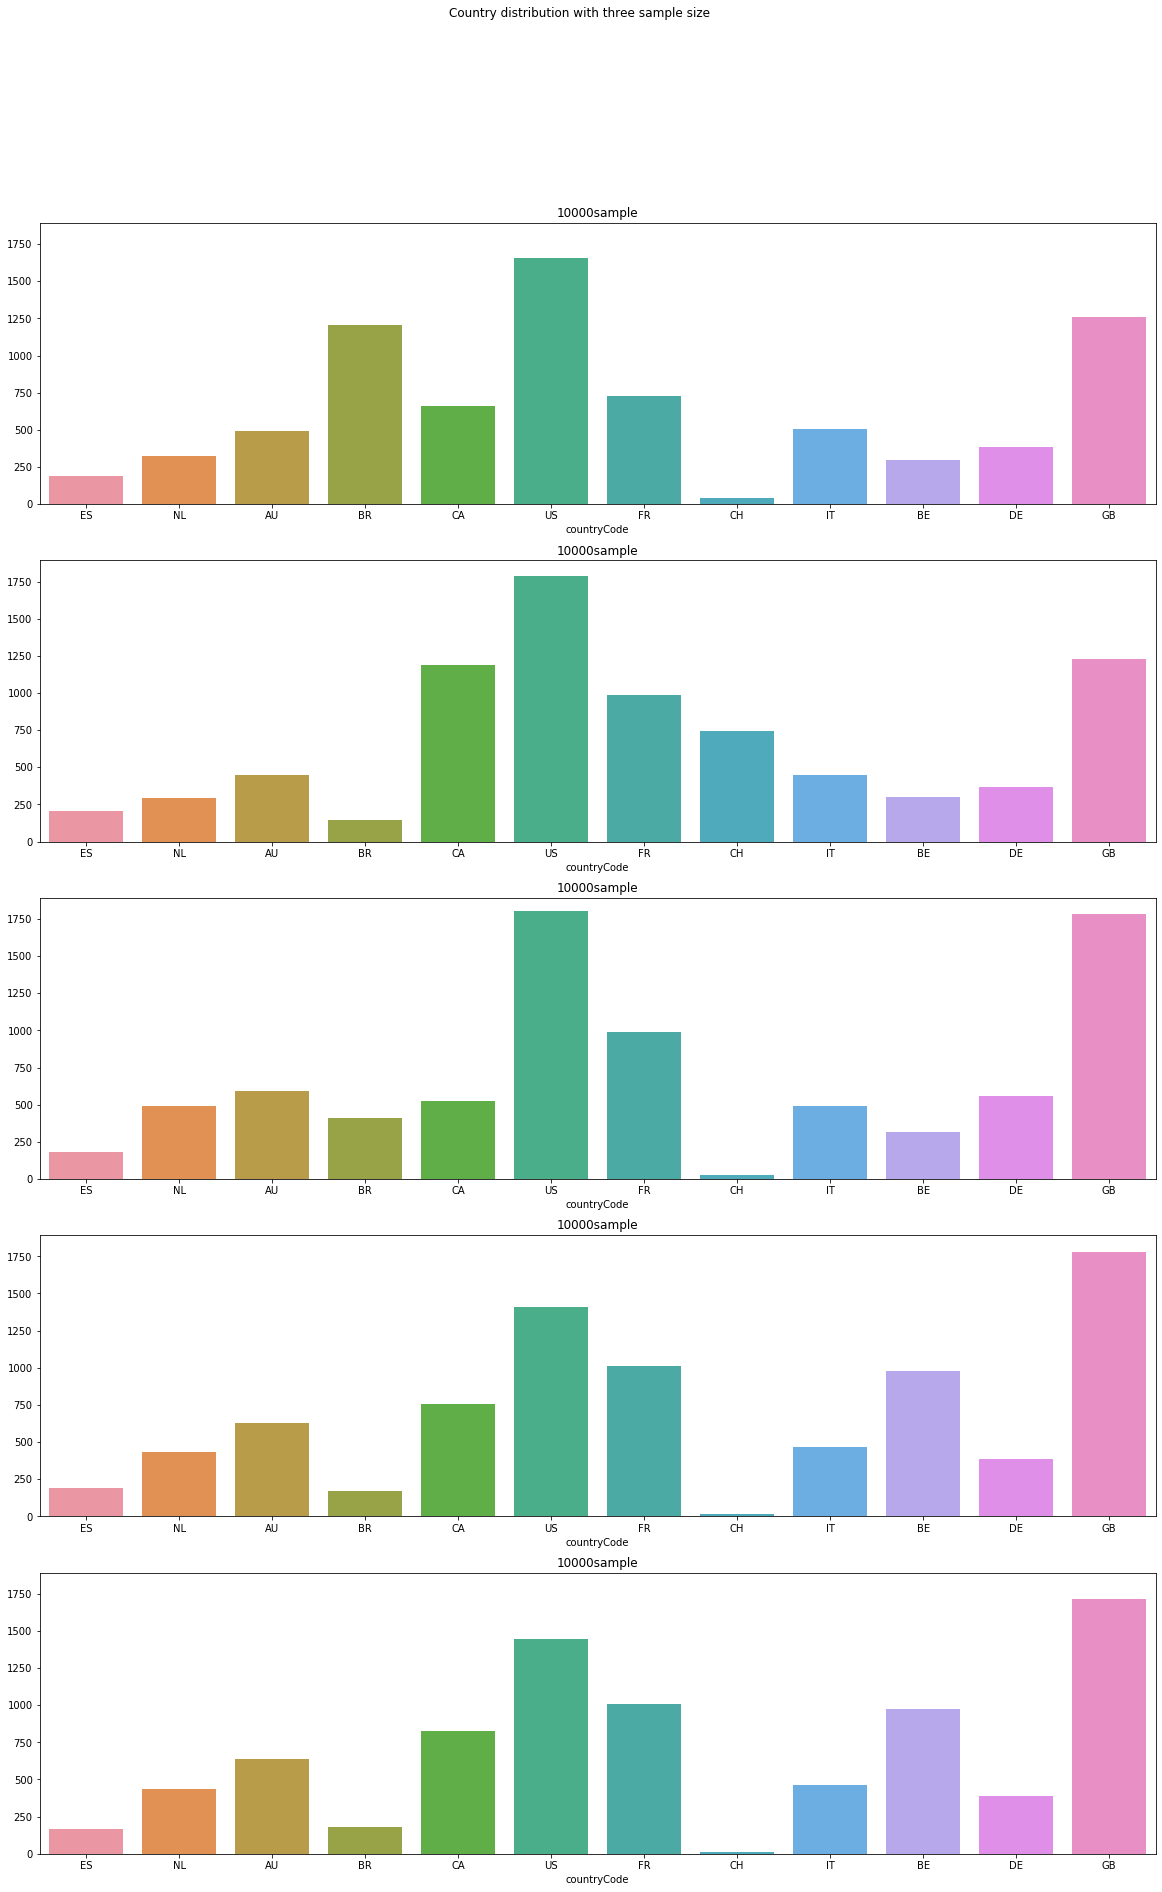

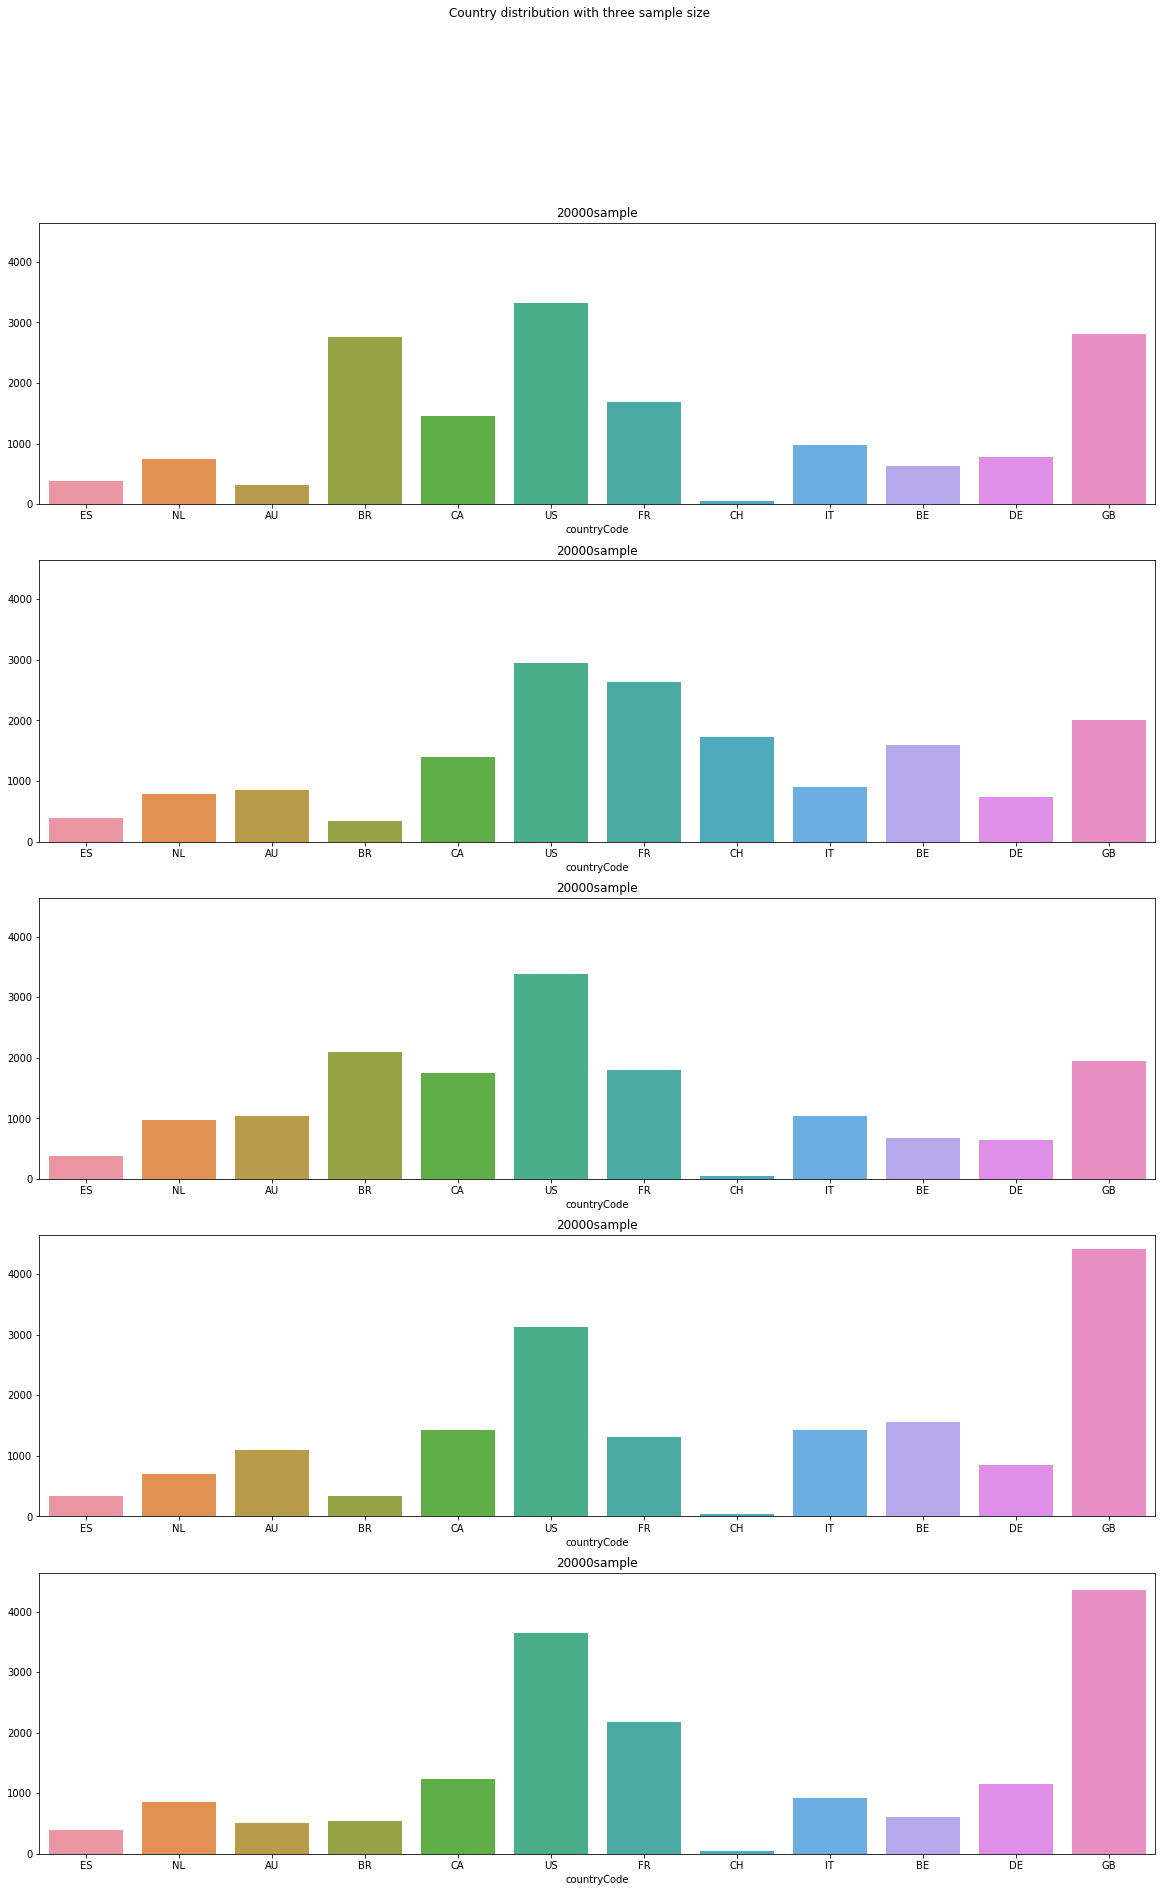

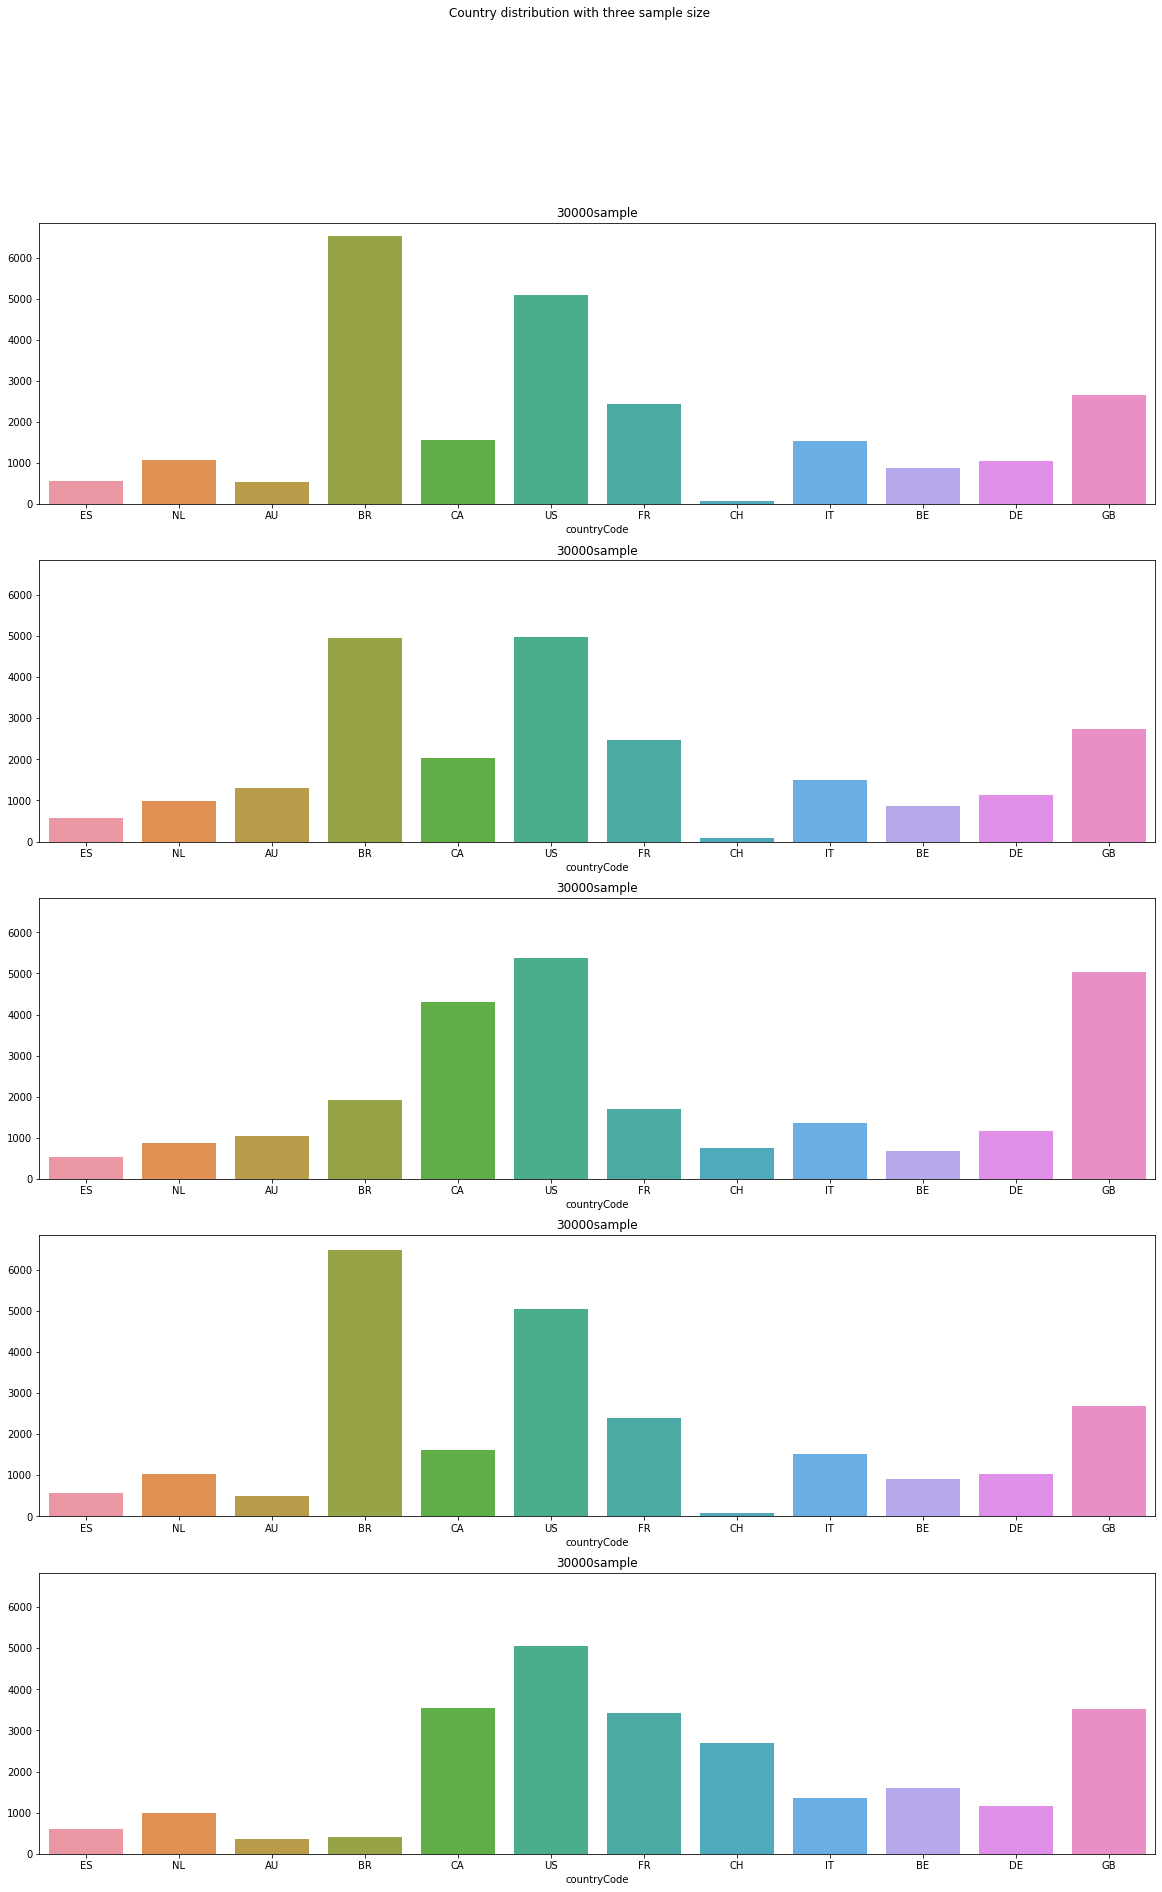

In [70]:
%matplotlib inline
for n in sample_size:
    fig, axes = plt.subplots(5, 1, figsize=(20, 30), sharey=True)
    fig.suptitle('Country distribution with three sample size')
    for i in range(5):
        sns.barplot(ax=axes[i], x=dct['lst_%s' % n][i].filter(
            items=ls_countries, axis=0).index, y=dct['lst_%s' % n][i].filter(items=ls_countries, axis=0).values)
        axes[i].set_title(str(n) + 'sample')

In [72]:
# Create a new dataframe to store the count of countries per sampling dataframe
types = {}
for n in sample_size:
    types['lst_%s' % n] = [globals()['df_sample_'+str(n)+'_'+str(i)].groupby(['type']
                                                                             ).count().sort_values(by='developer_email', ascending=False)['developer_email'] for i in range(5)]

## Plot bar chart for number of queries per type in each sampling datafarme

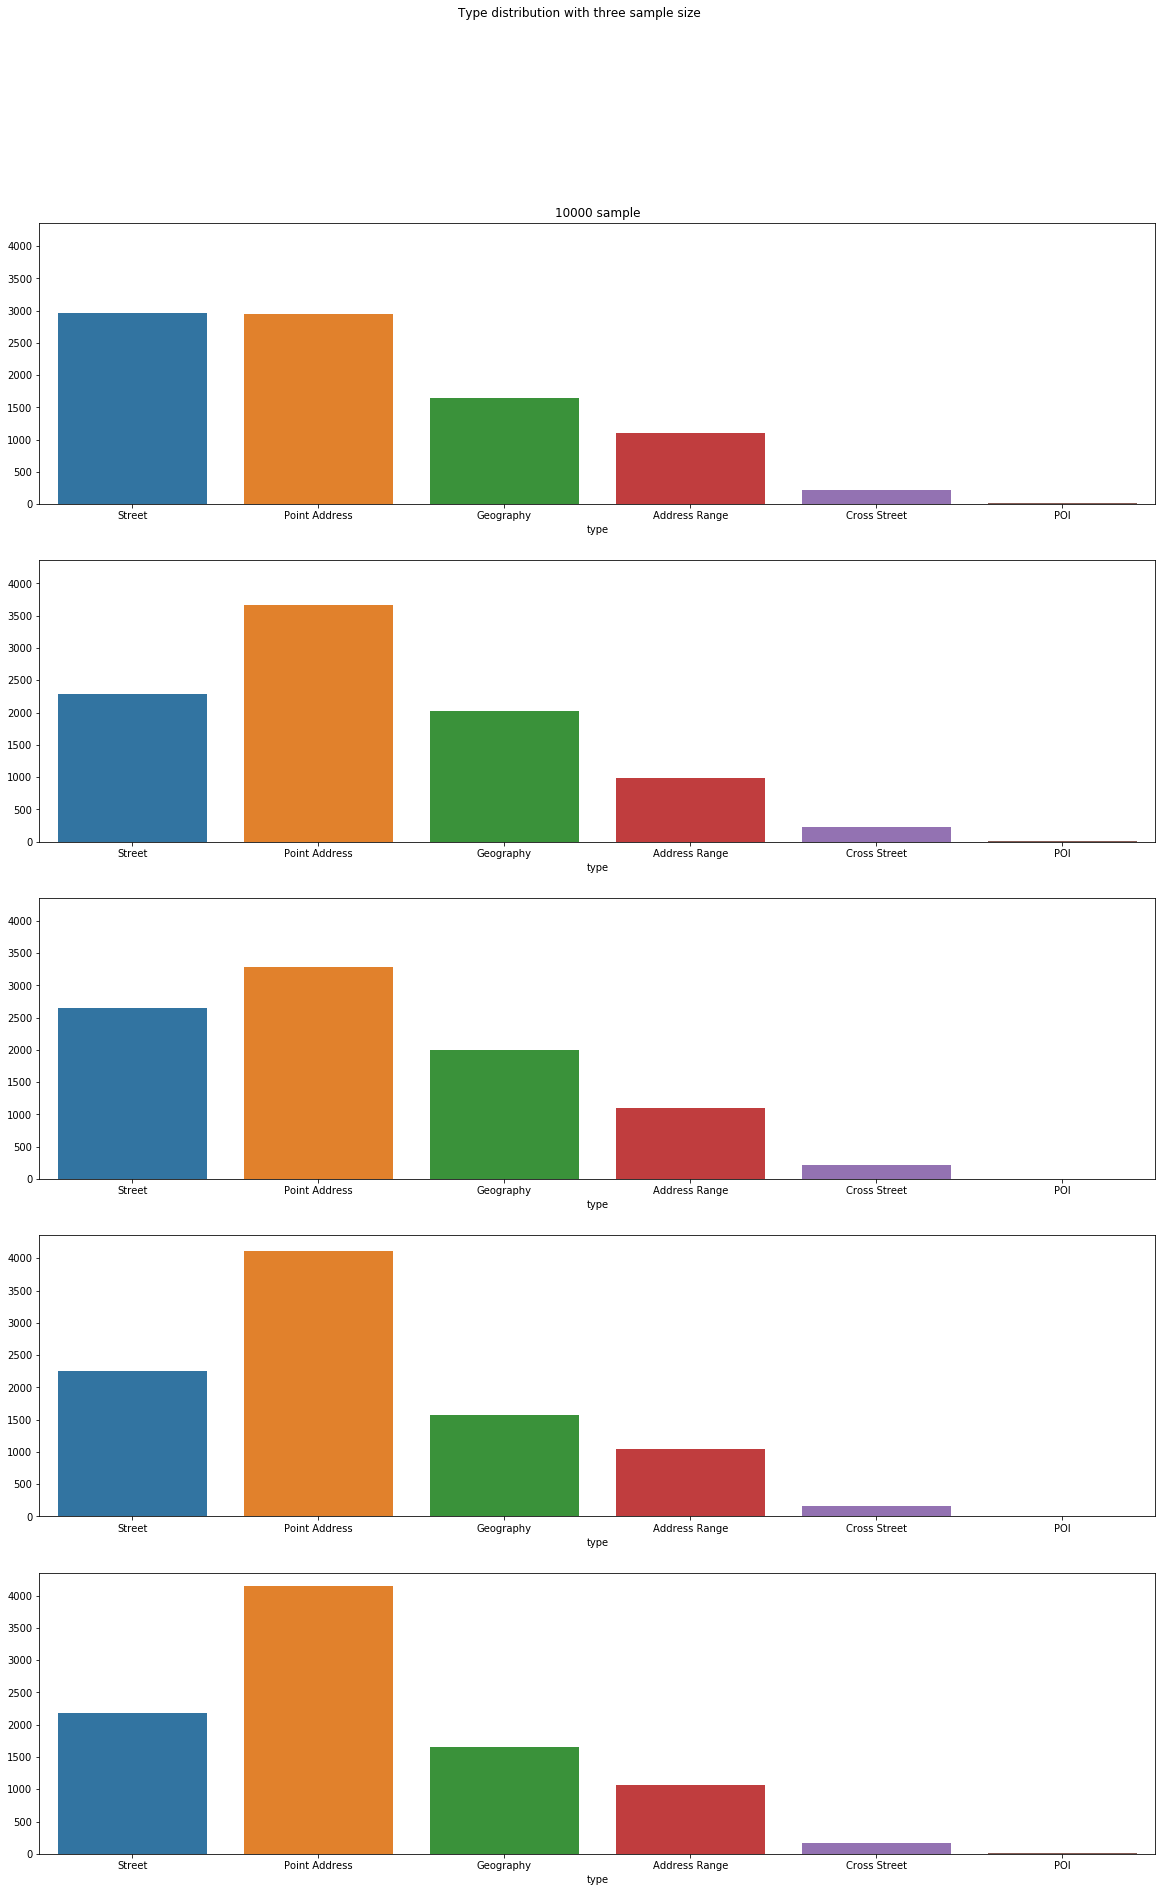

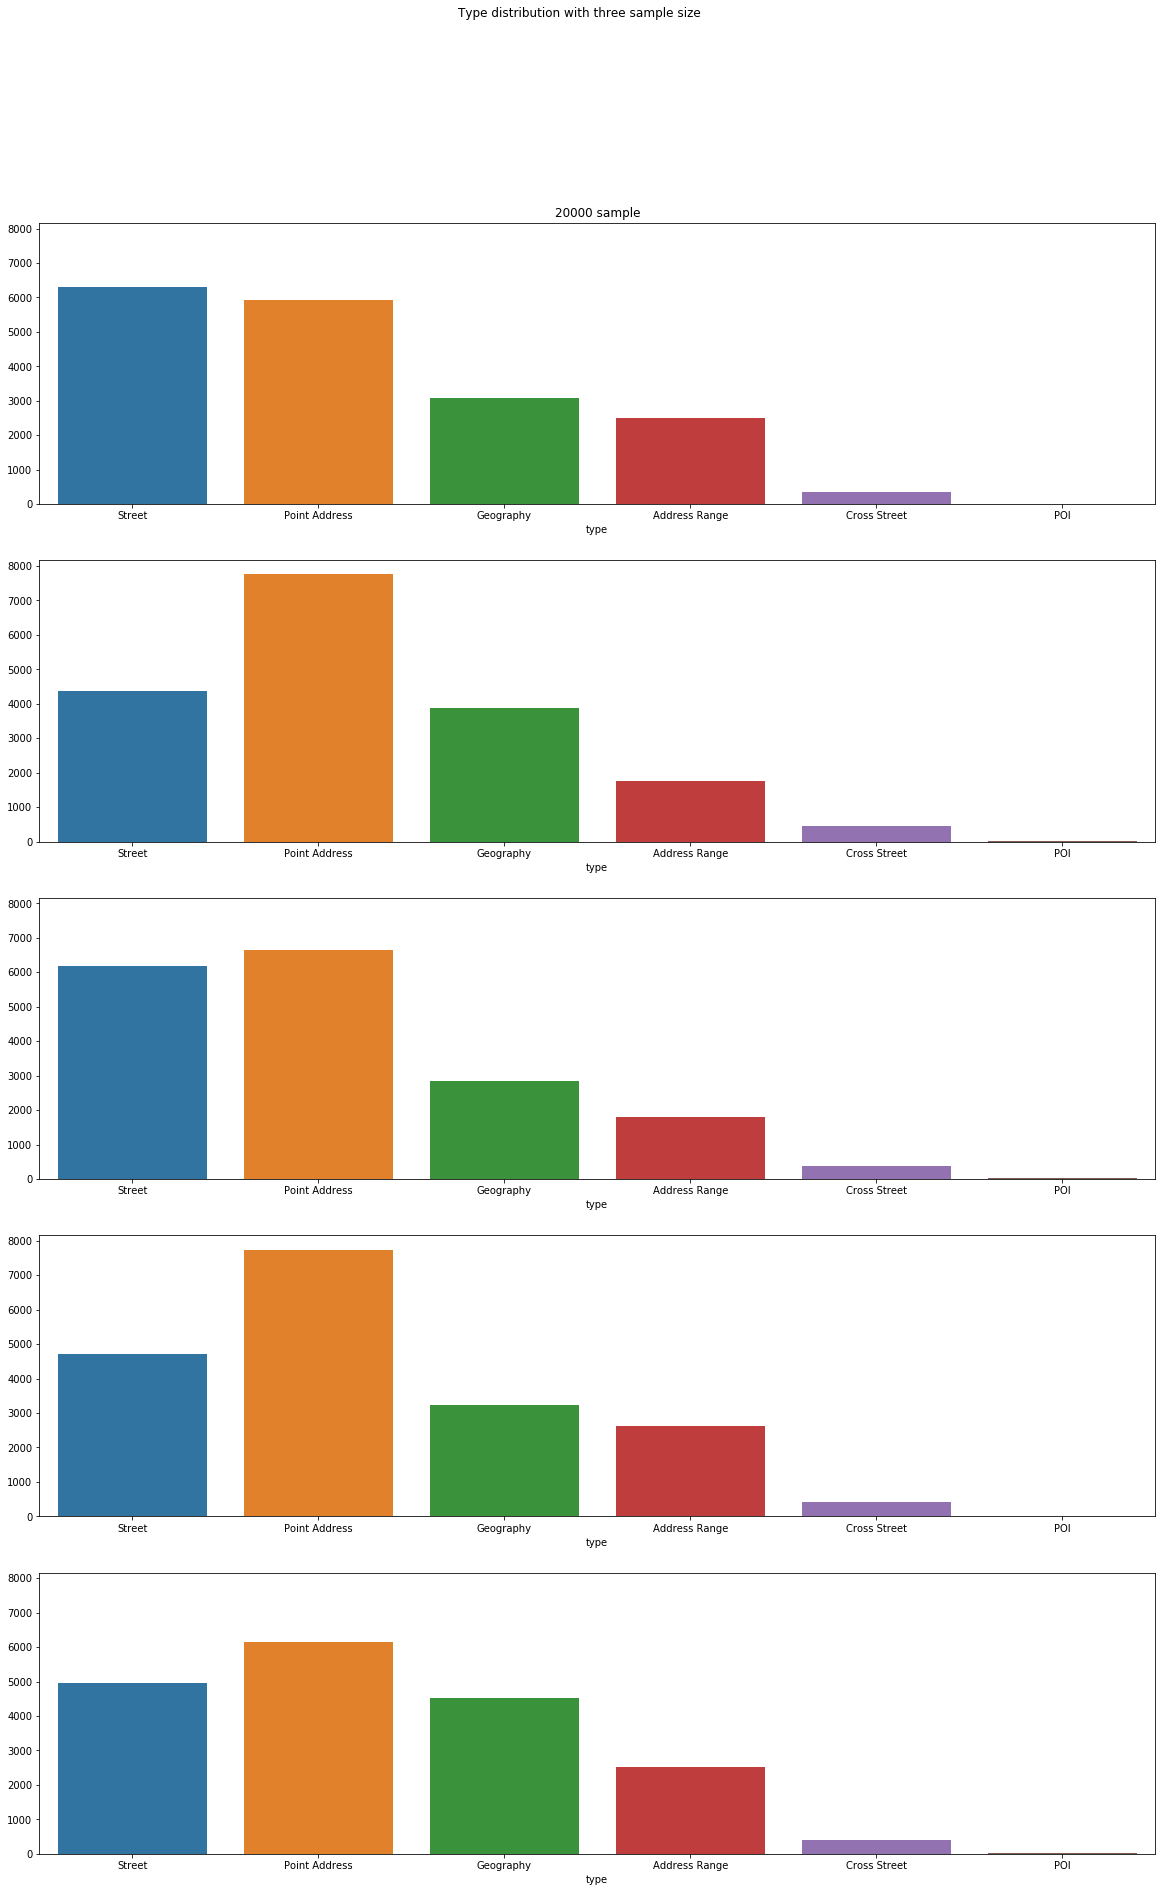

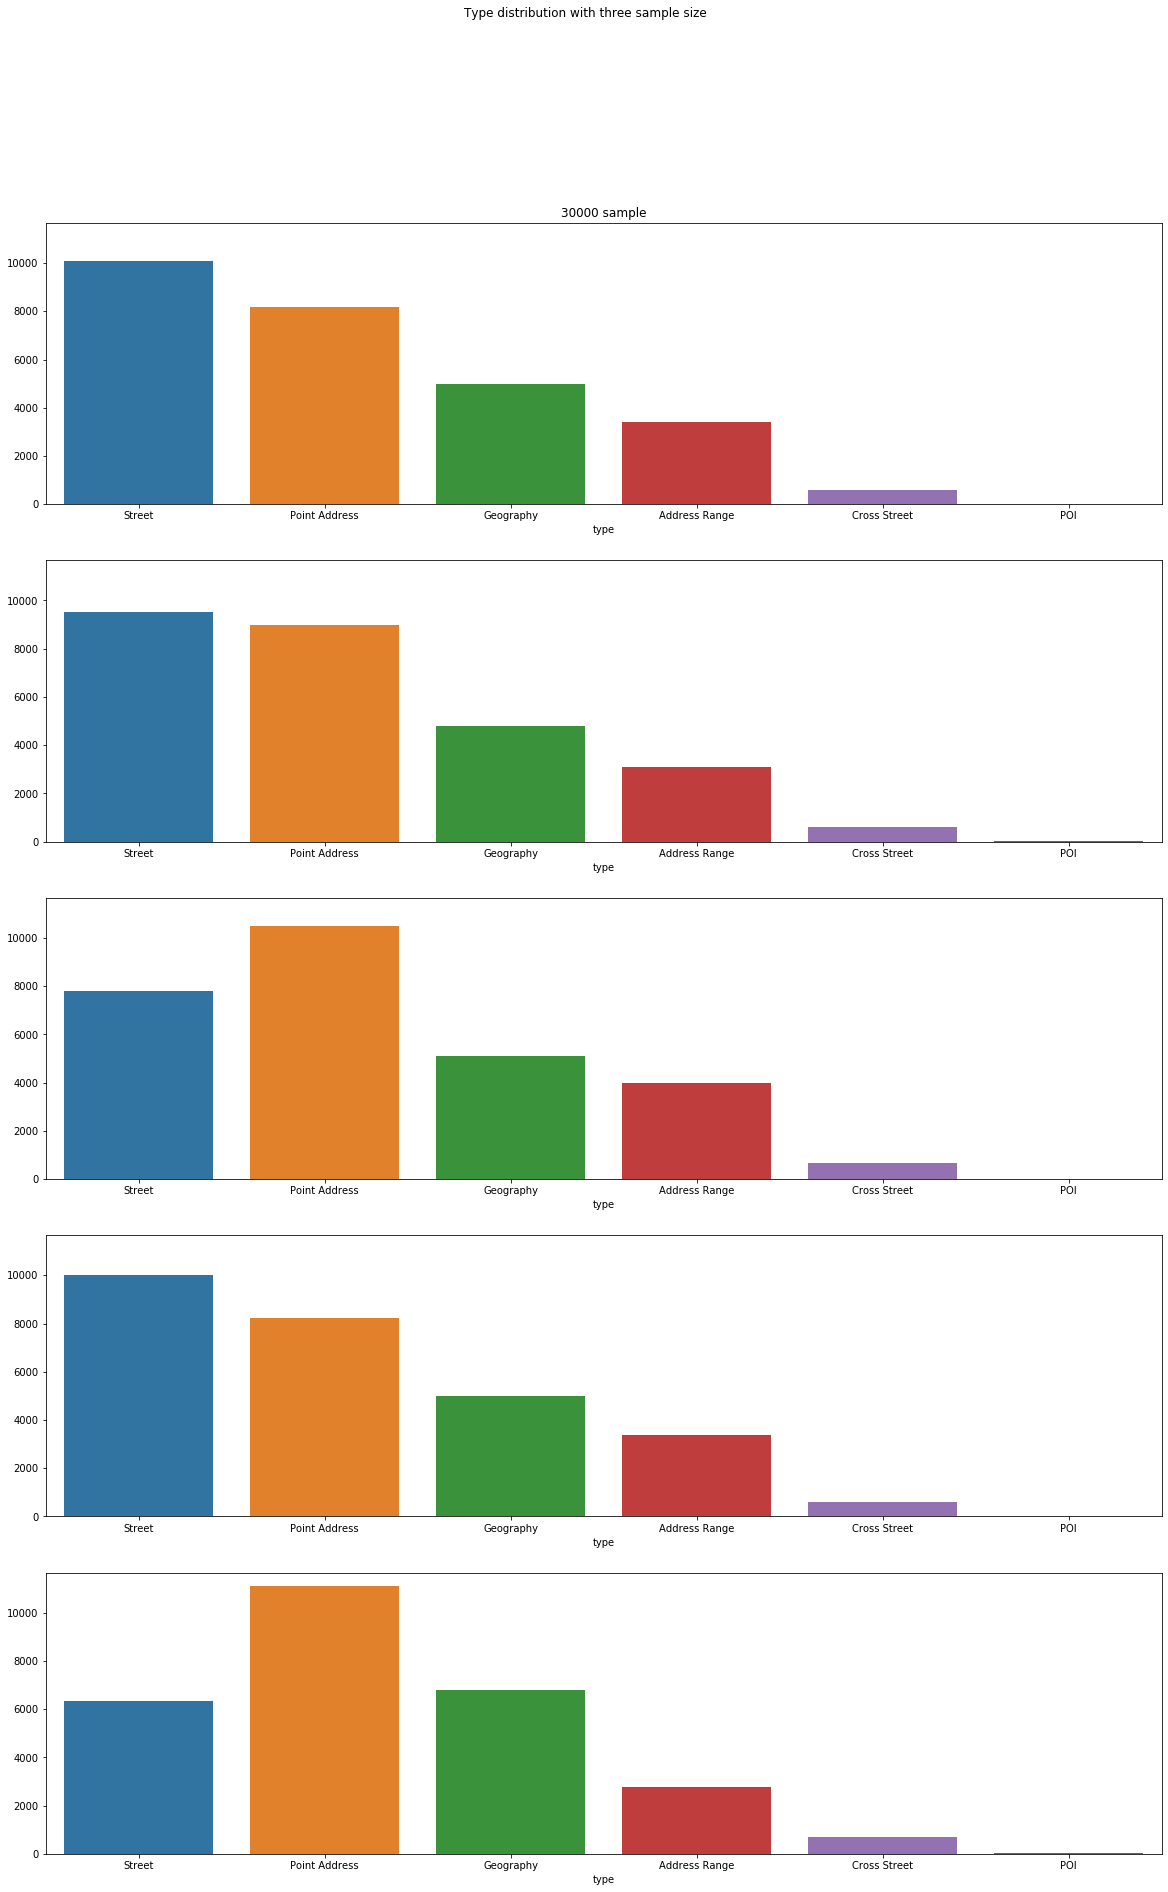

In [76]:
# Bar plot for quereis per type in each sampling dataframe
ls_types = ['Street', 'Point Address', 'Geography',
            'Address Range', 'Cross Street', 'POI']
%matplotlib inline
for n in sample_size:
    fig, axes = plt.subplots(5, 1, figsize=(20, 30), sharey=True)
    fig.suptitle('Type distribution with three sample size')
    for i in range(5):
        sns.barplot(ax=axes[i], x=types['lst_%s' % n][i].filter(
            items=ls_types, axis=0).index, y=types['lst_%s' % n][i].filter(items=ls_types, axis=0).values)
        if i == 0:
            axes[i].set_title(str(n) + ' sample')

# Client based verification of countries

In [88]:
# Function to plot a bar chart for number of queries per country for each cutomer and each sampling dataframe
def sample_country_customer(developer_email, sample_size, n_df_samples):
    """
    Returns bar plots (how many? sample_size * n_df_samples)
    
    input:
        - developer_email: a string, developer email
        - sample_size: list of integers representing the sampling quantities
        - n_df_samples: int, how many dataframe we sample for each size
    output:
        - bar plots
    """
    for n in sample_size:
        for i in range(n_df_samples):
            globals()[developer_email+str(n)+'_'+str(i)] = pd.DataFrame()
            df_temp = globals()['df_sample_'+str(n)+'_'+str(i)][globals()['df_sample_' +
                                                                          str(n)+'_'+str(i)]['developer_email'] == developer_email]
            globals()[developer_email+str(n)+'_'+str(i)] = pd.concat([globals()
                                                                      [developer_email+str(n)+'_'+str(i)], df_temp])
            # Create a new dataframe to store the count of countries per sampling dataframe
    dct_client = {}
    for n in sample_size:
        dct_client['lst_%s' % n] = [globals()[developer_email+str(n)+'_'+str(i)].groupby(['countryCode']
                                                                                         ).count().sort_values(by='developer_email', ascending=False)['developer_email'] for i in range(n_df_samples)]
    %matplotlib inline
    for n in sample_size:
        fig, axes = plt.subplots(n_df_samples, 1, figsize=(20, 30), sharey=True)
        fig.suptitle('Country distribution with three sample size for' + developer_email)
        for i in range(n_df_samples):
            sns.barplot(ax=axes[i], x=dct_client['lst_%s' % n][i].filter(
                items=ls_countries, axis=0).index, y=dct_client['lst_%s' % n][i].filter(items=ls_countries, axis=0).values)
            axes[i].set_title(str(n) + 'sample')

## Examples

### VZ.NBI.VLT.ClassicPartner@verizon.com

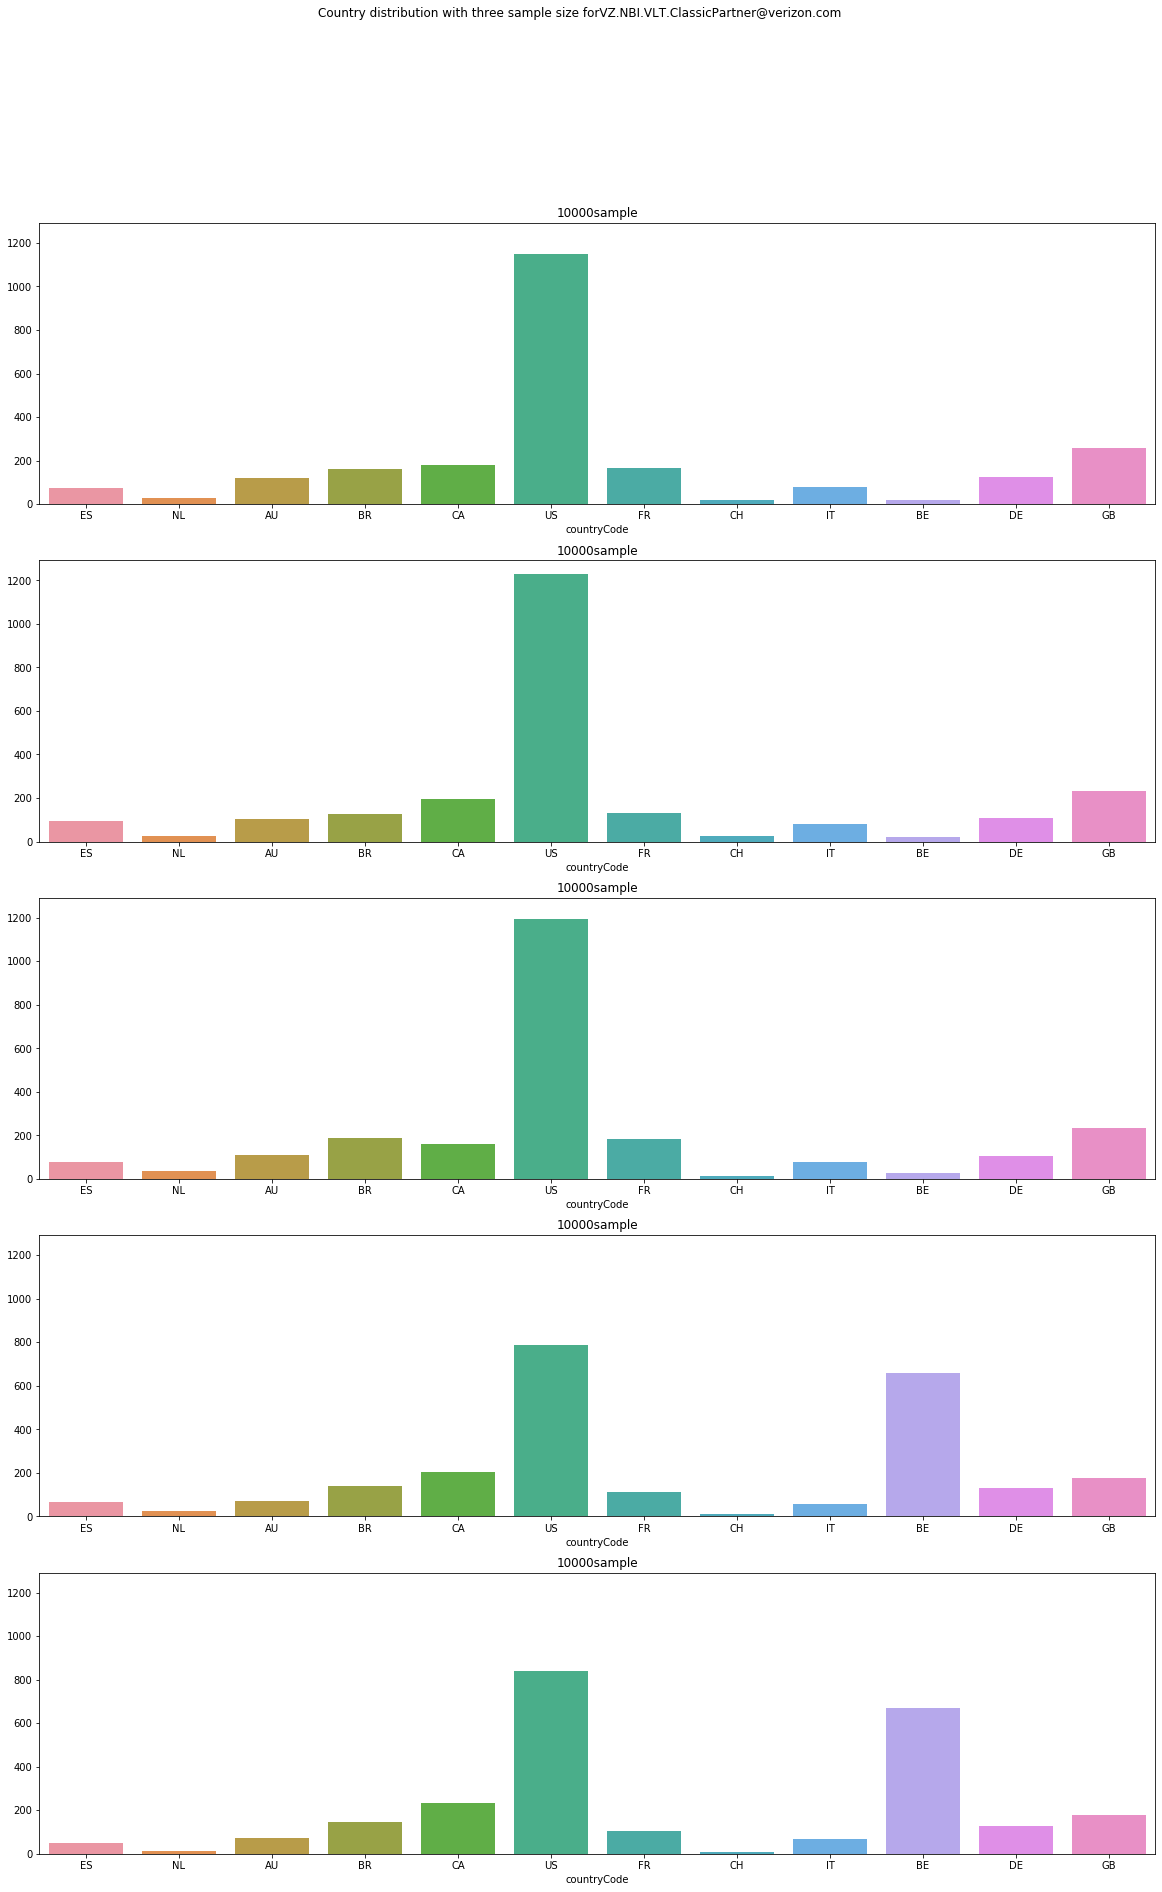

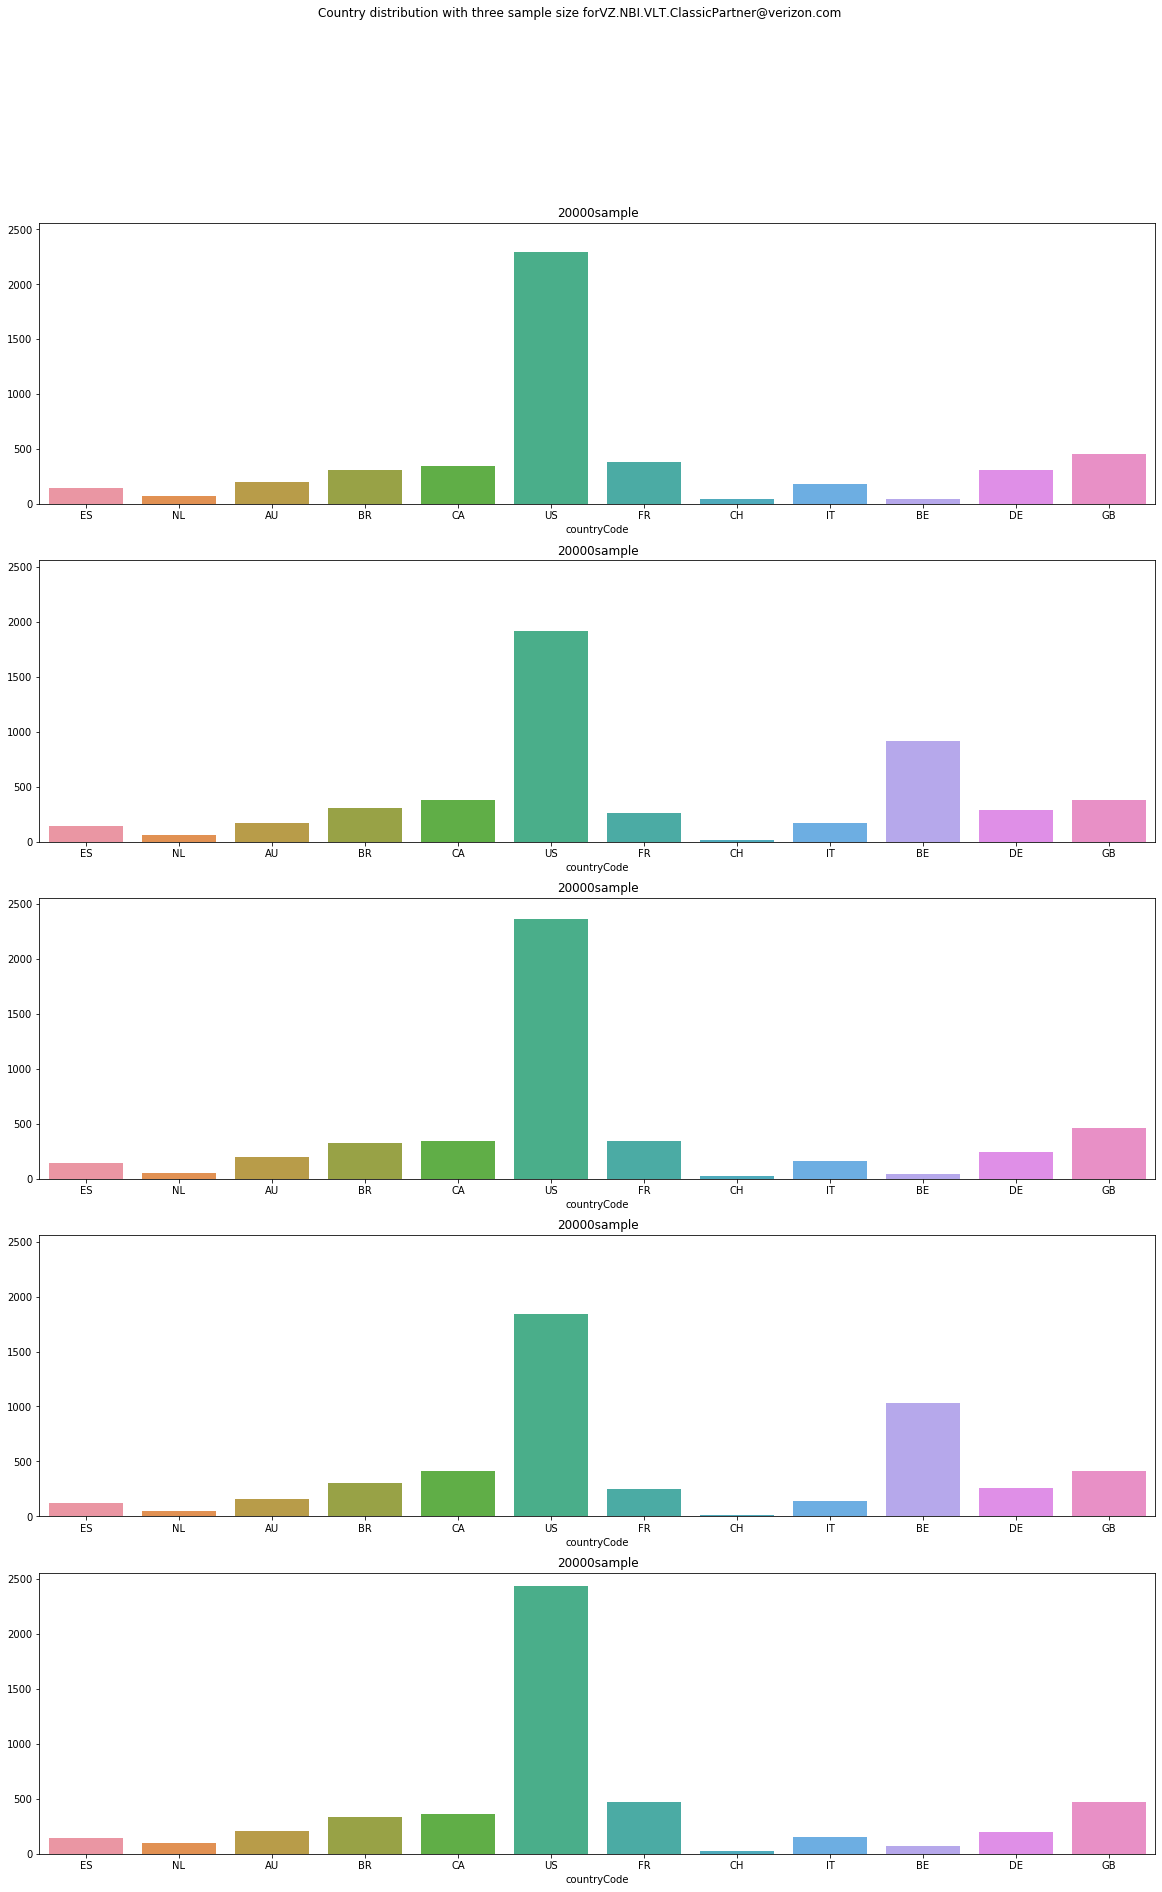

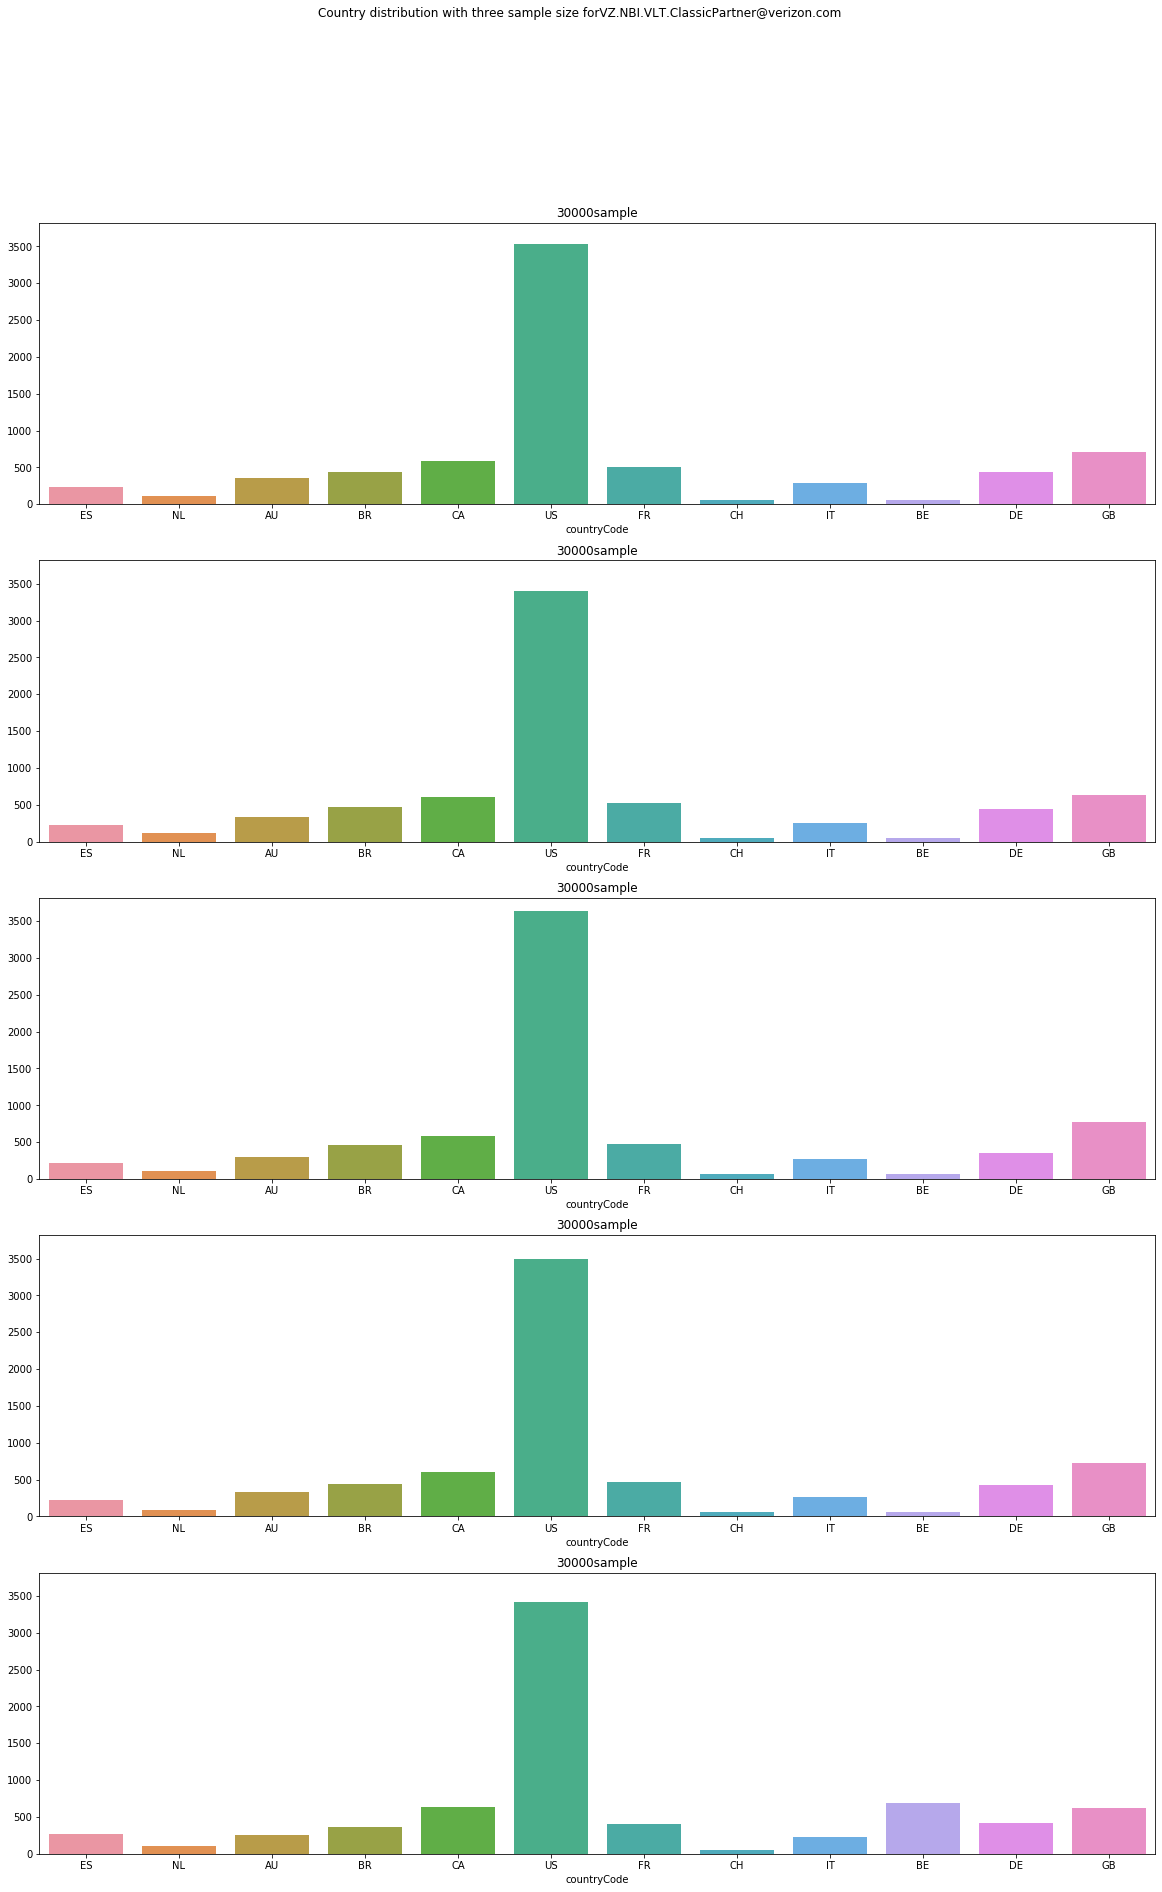

In [89]:
sample_country_customer("VZ.NBI.VLT.ClassicPartner@verizon.com", sample_size, n_df_samples)

### data_products@alteryx.com

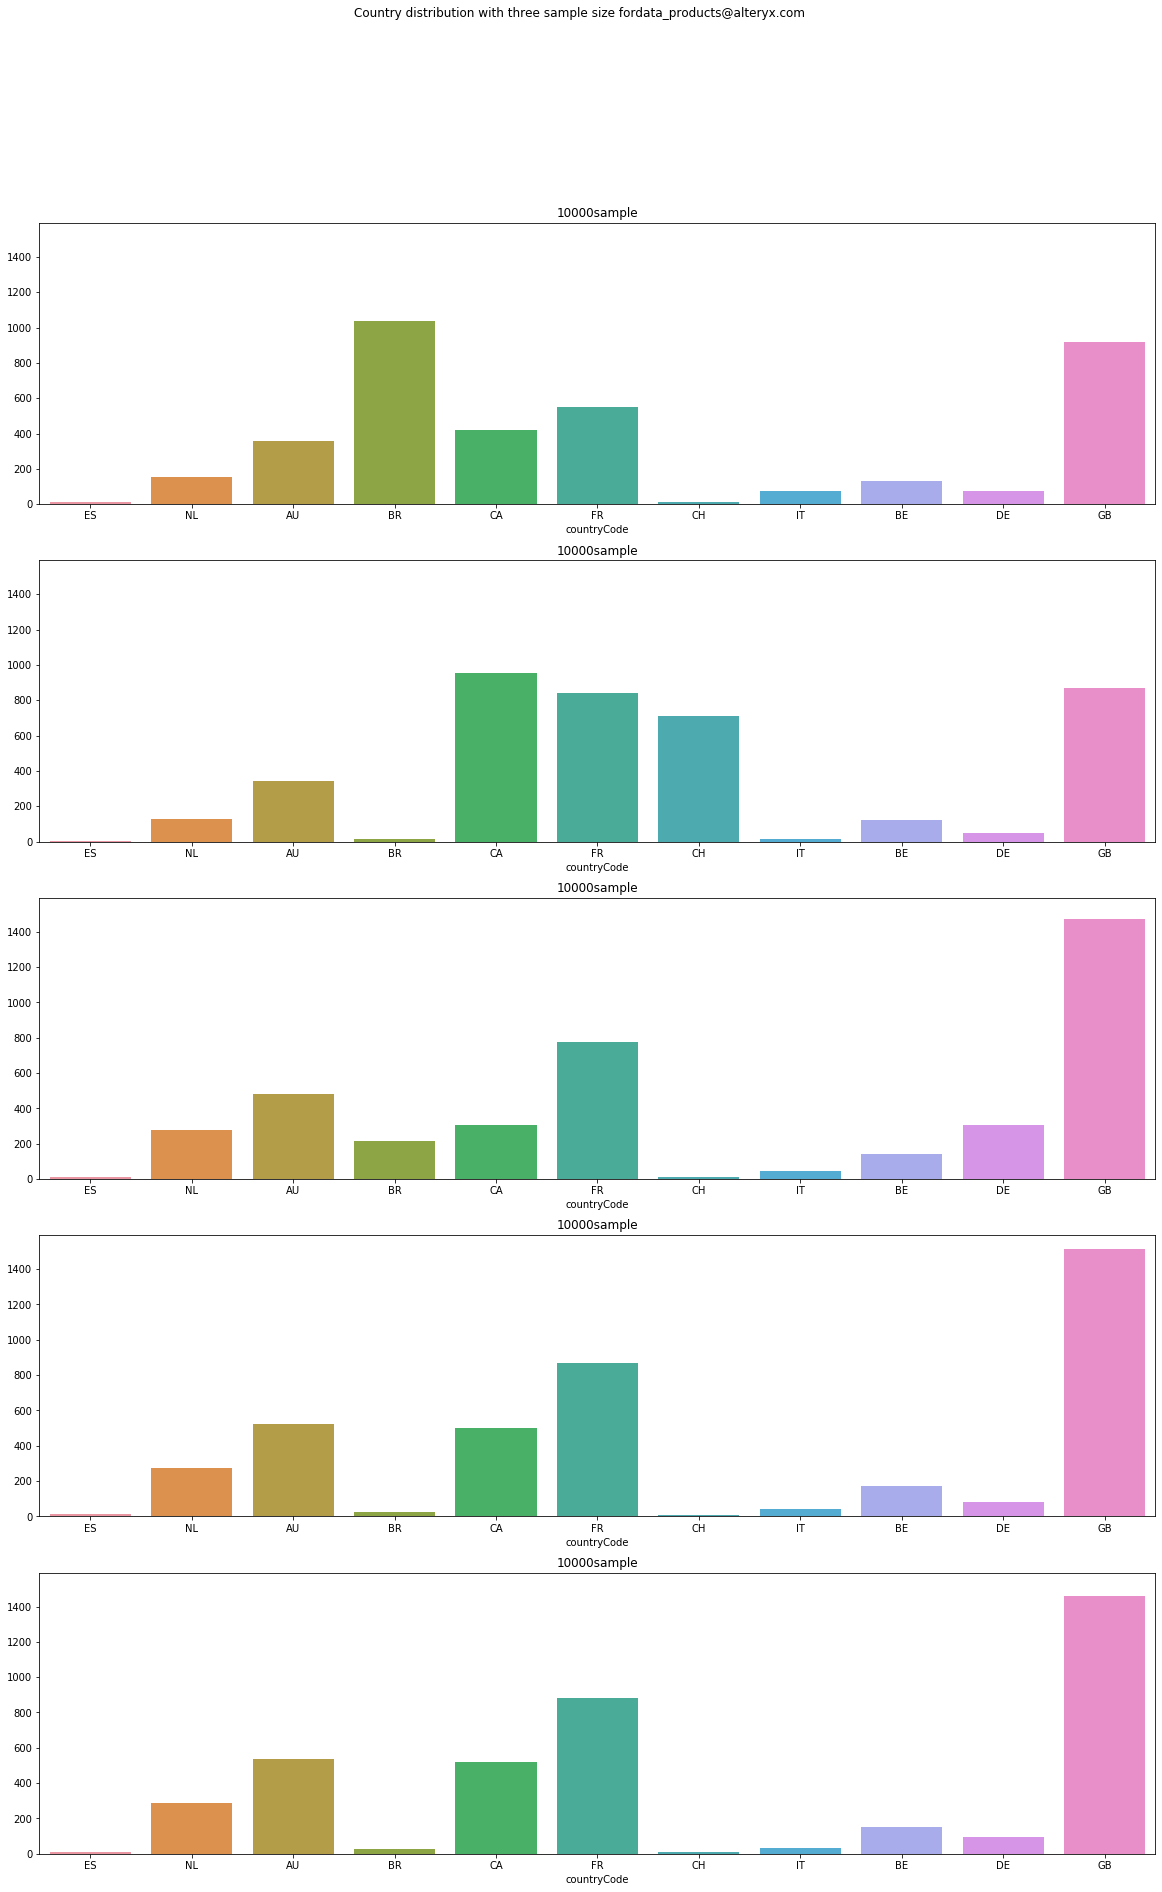

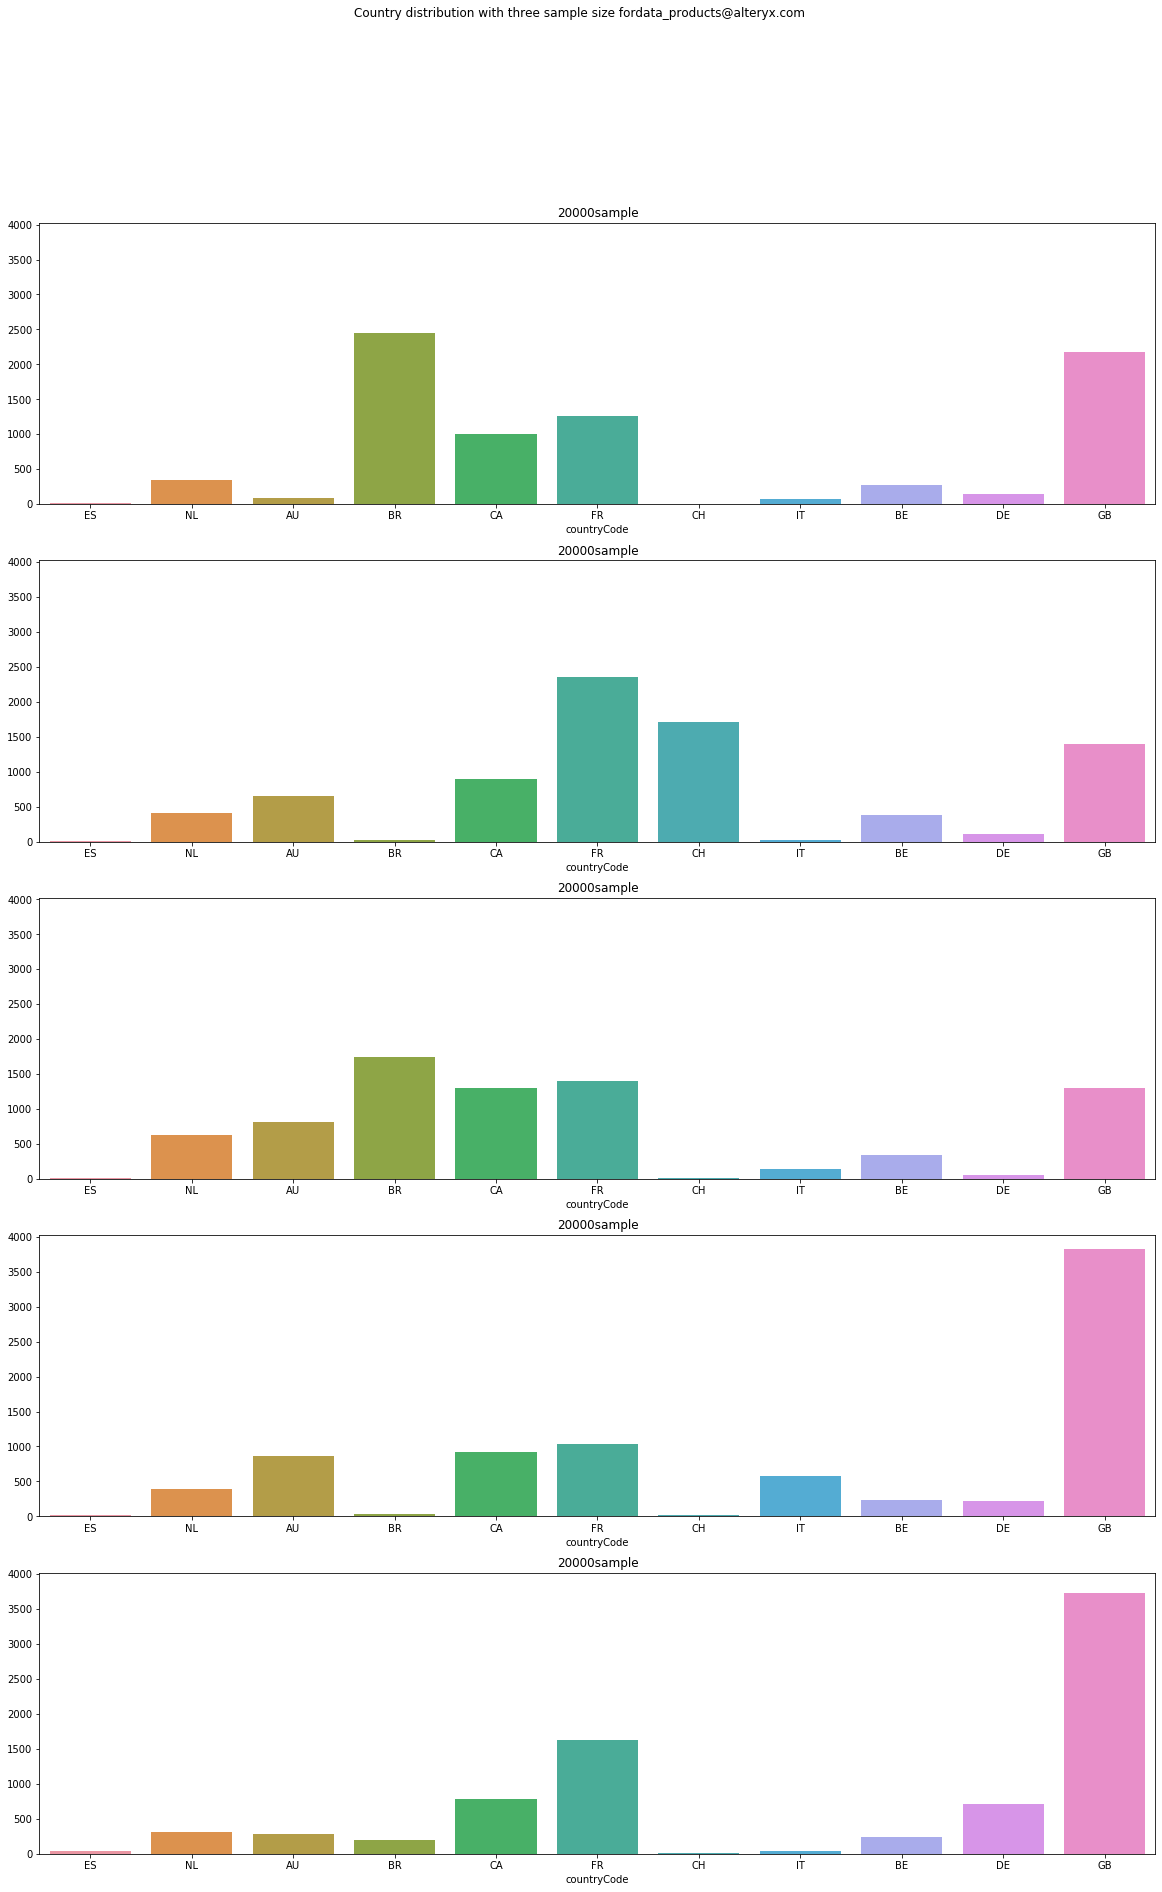

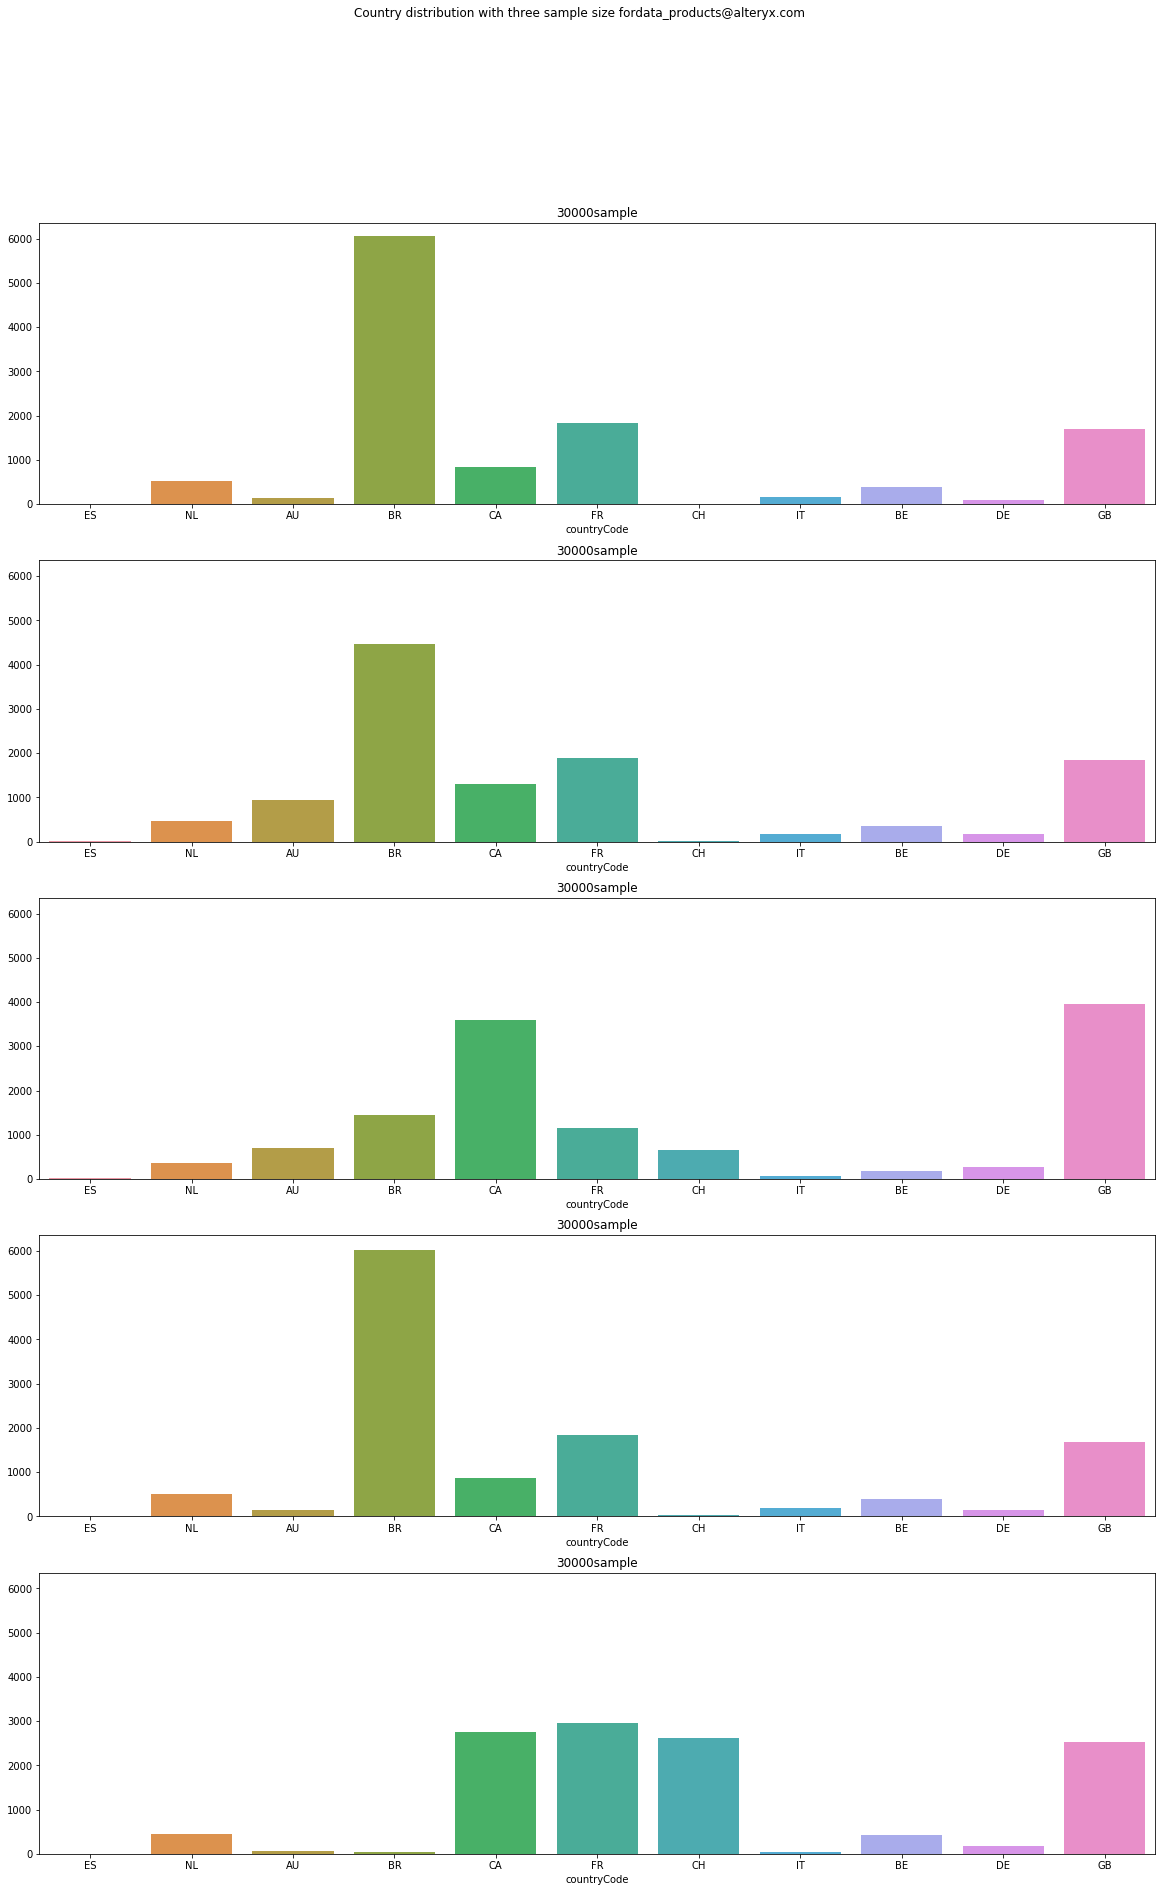

In [90]:
sample_country_customer("data_products@alteryx.com", sample_size, n_df_samples)

# Client based verification of types

In [92]:
# Function to plot a bar chart for number of queries per tyepe for each cutomer and each sampling dataframe
def sample_type_customer(developer_email, sample_size, n_df_samples):
    """
    Returns bar plots (how many? sample_size * n_df_samples)
    
    input:
        - developer_email: a string, developer email
        - sample_size: list of integers representing the sampling quantities
        - n_df_samples: int, how many dataframe we sample for each size
    output:
        - bar plots
    """
    for n in sample_size:
        for i in range(n_df_samples):
            globals()[developer_email+str(n)+'_'+str(i)] = pd.DataFrame()
            df_temp = globals()['df_sample_'+str(n)+'_'+str(i)][globals()['df_sample_' +
                                                                          str(n)+'_'+str(i)]['developer_email'] == developer_email]
            globals()[developer_email+str(n)+'_'+str(i)] = pd.concat([globals()
                                                                      [developer_email+str(n)+'_'+str(i)], df_temp])
            # Create a new dataframe to store the count of countries per sampling dataframe
    dct_client = {}
    for n in sample_size:
        dct_client['lst_%s' % n] = [globals()[developer_email+str(n)+'_'+str(i)].groupby(['type']
                                                                                         ).count().sort_values(by='developer_email', ascending=False)['developer_email'] for i in range(n_df_samples)]
    %matplotlib inline
    for n in sample_size:
        fig, axes = plt.subplots(n_df_samples, 1, figsize=(20, 30), sharey=True)
        fig.suptitle('Type distribution with three sample size for ' + developer_email)
        for i in range(n_df_samples):
            sns.barplot(ax=axes[i], x=dct_client['lst_%s' % n][i].filter(
                items=ls_types, axis=0).index, y=dct_client['lst_%s' % n][i].filter(items=ls_types, axis=0).values)
            axes[i].set_title(str(n) + 'sample')

## Examples

### data_products@alteryx.com

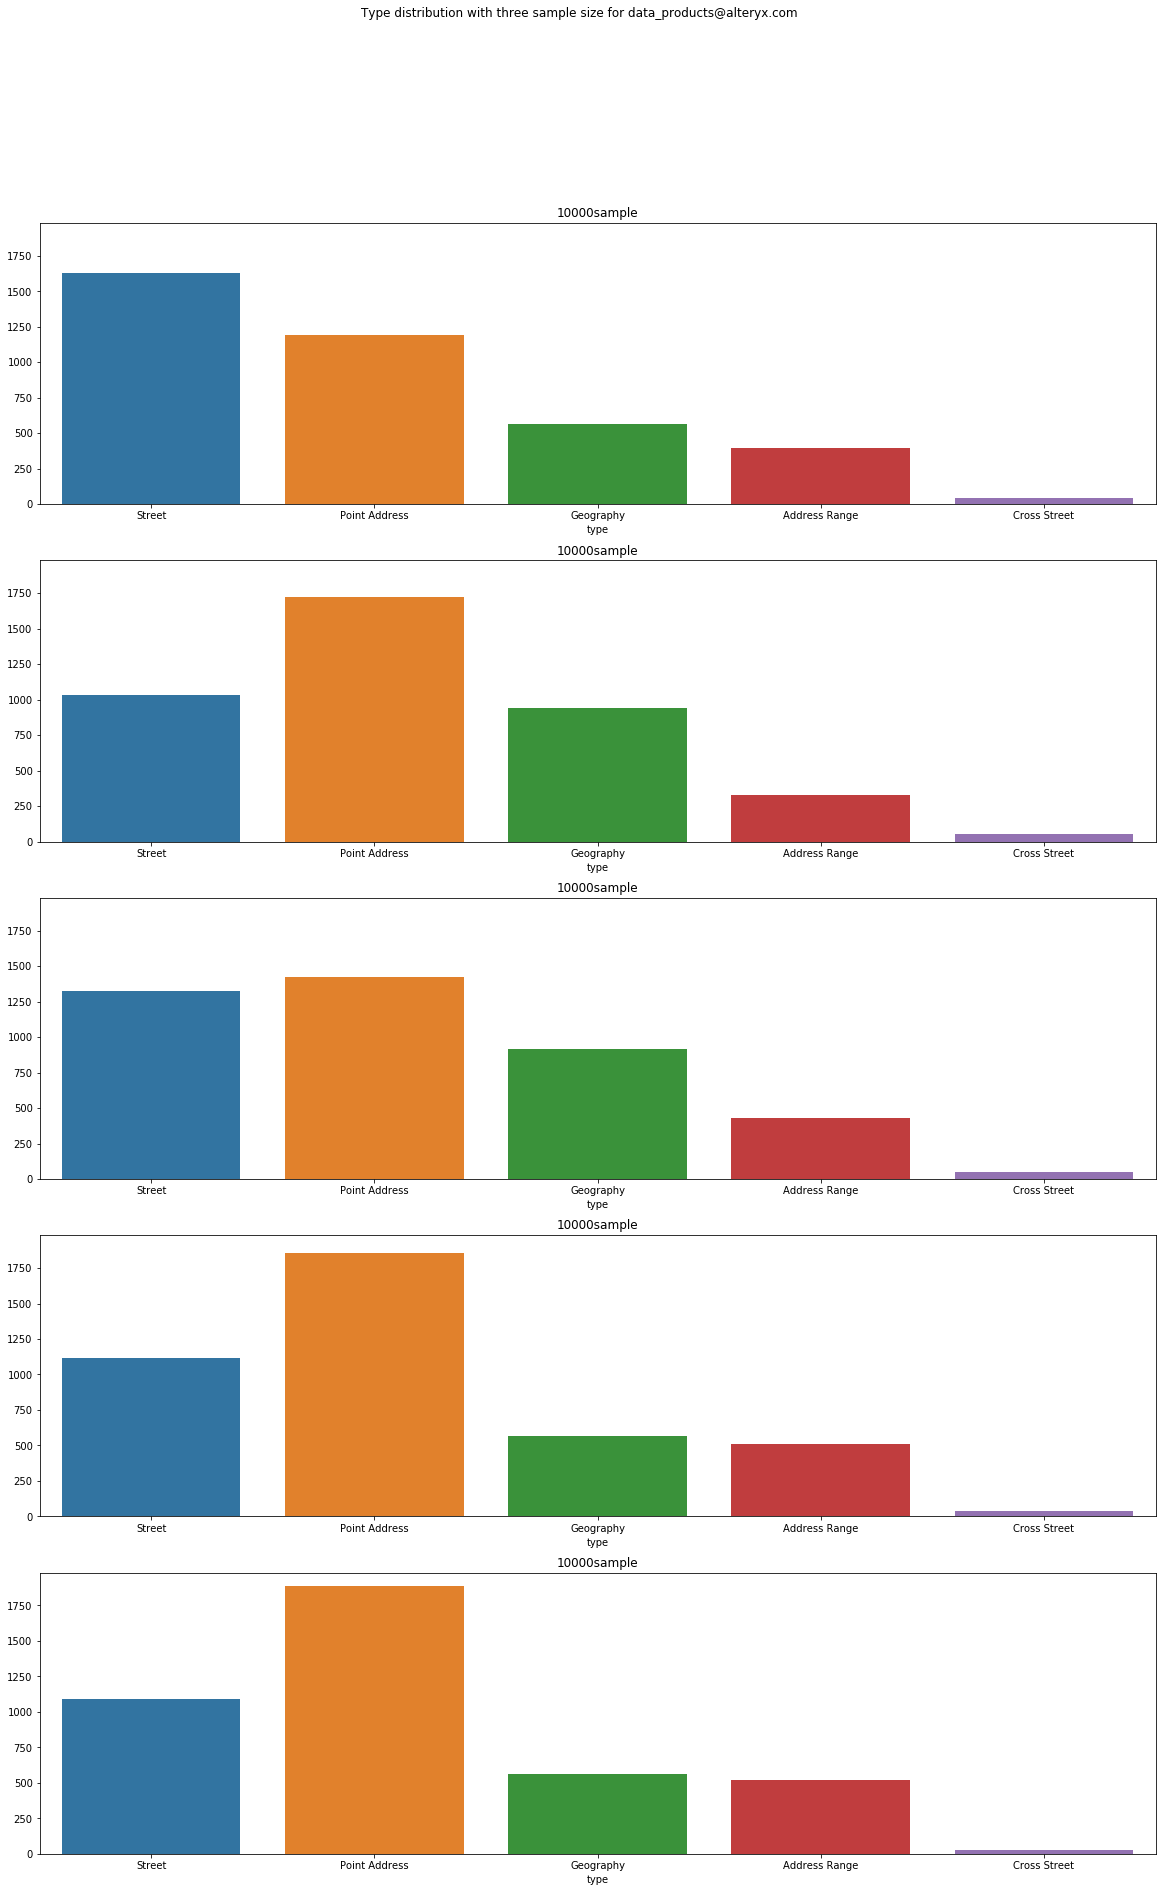

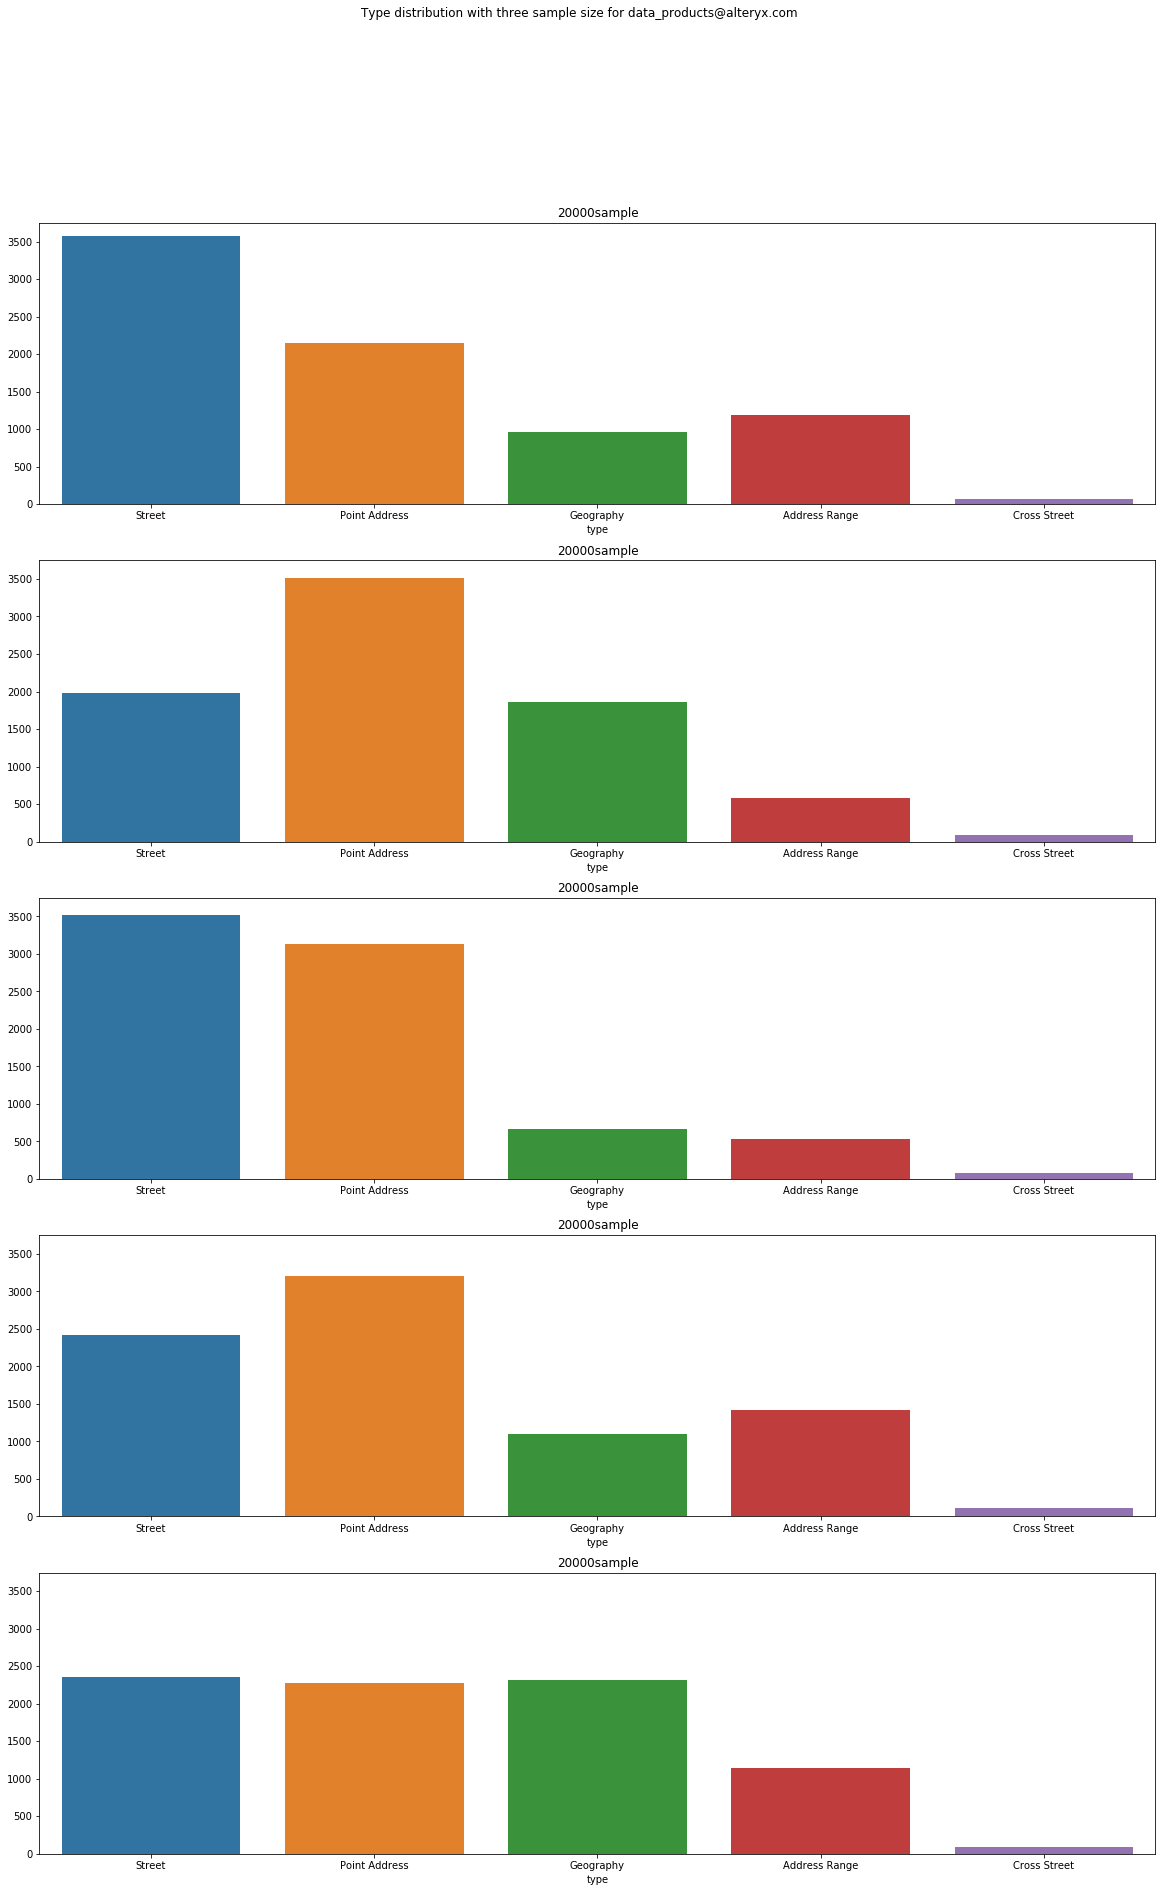

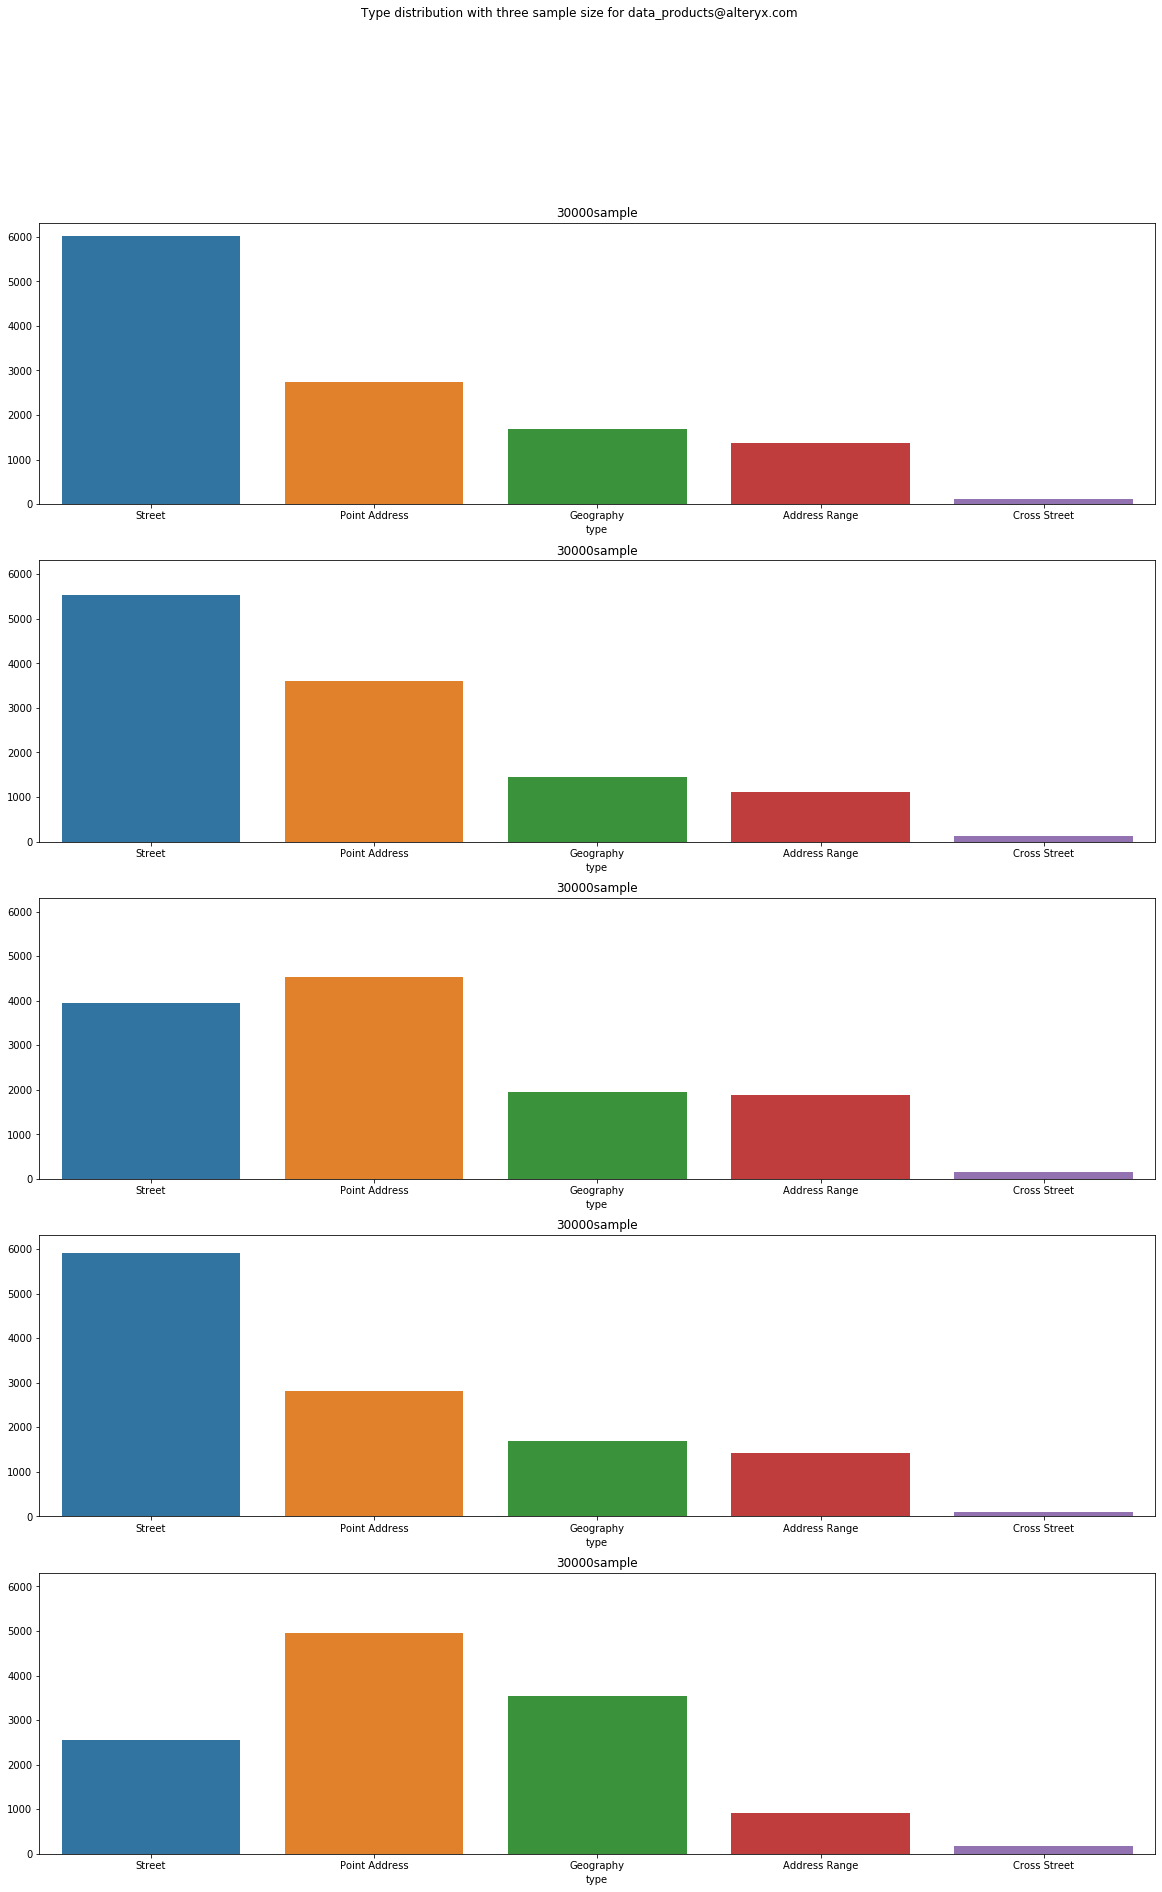

In [93]:
sample_type_customer("data_products@alteryx.com", sample_size, n_df_samples)

### VZ.NBI.VLT.ClassicPartner@verizon.com

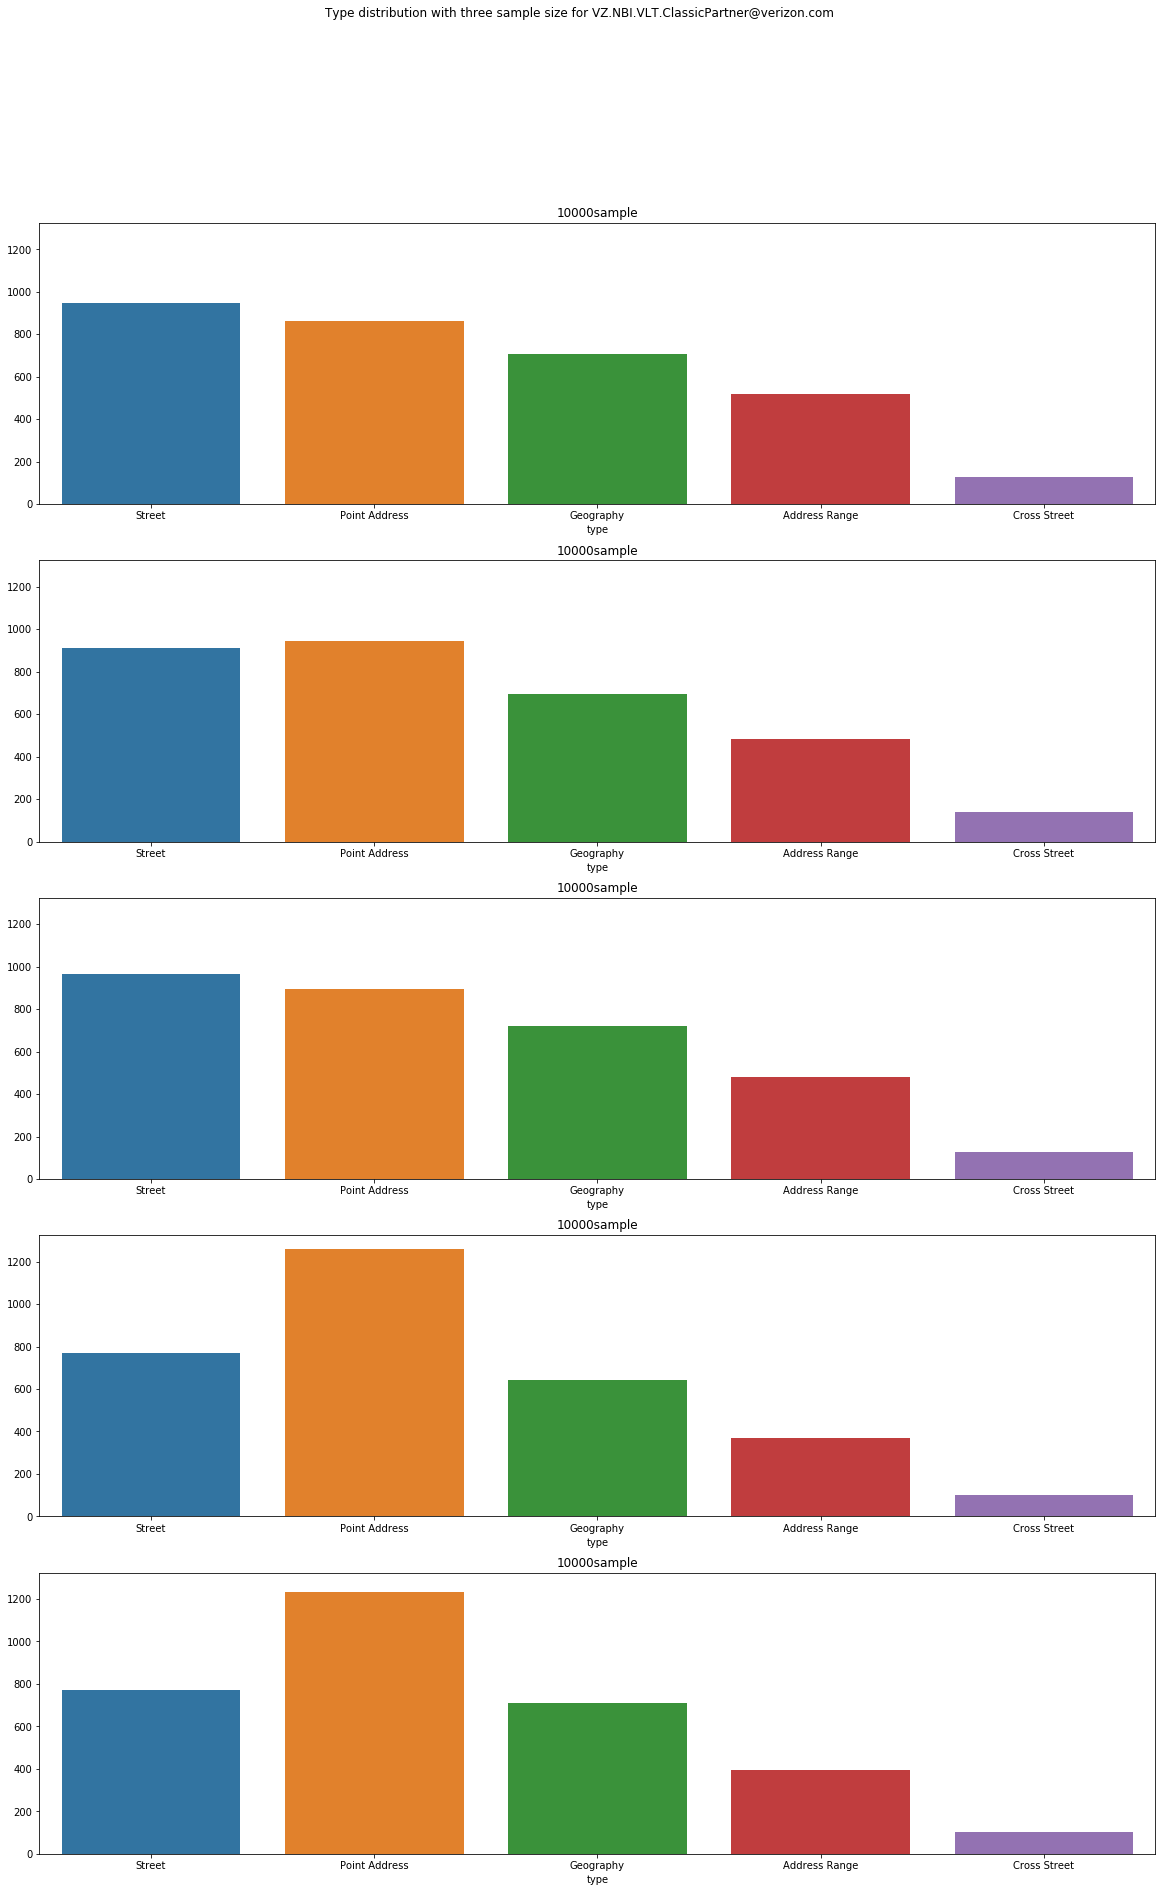

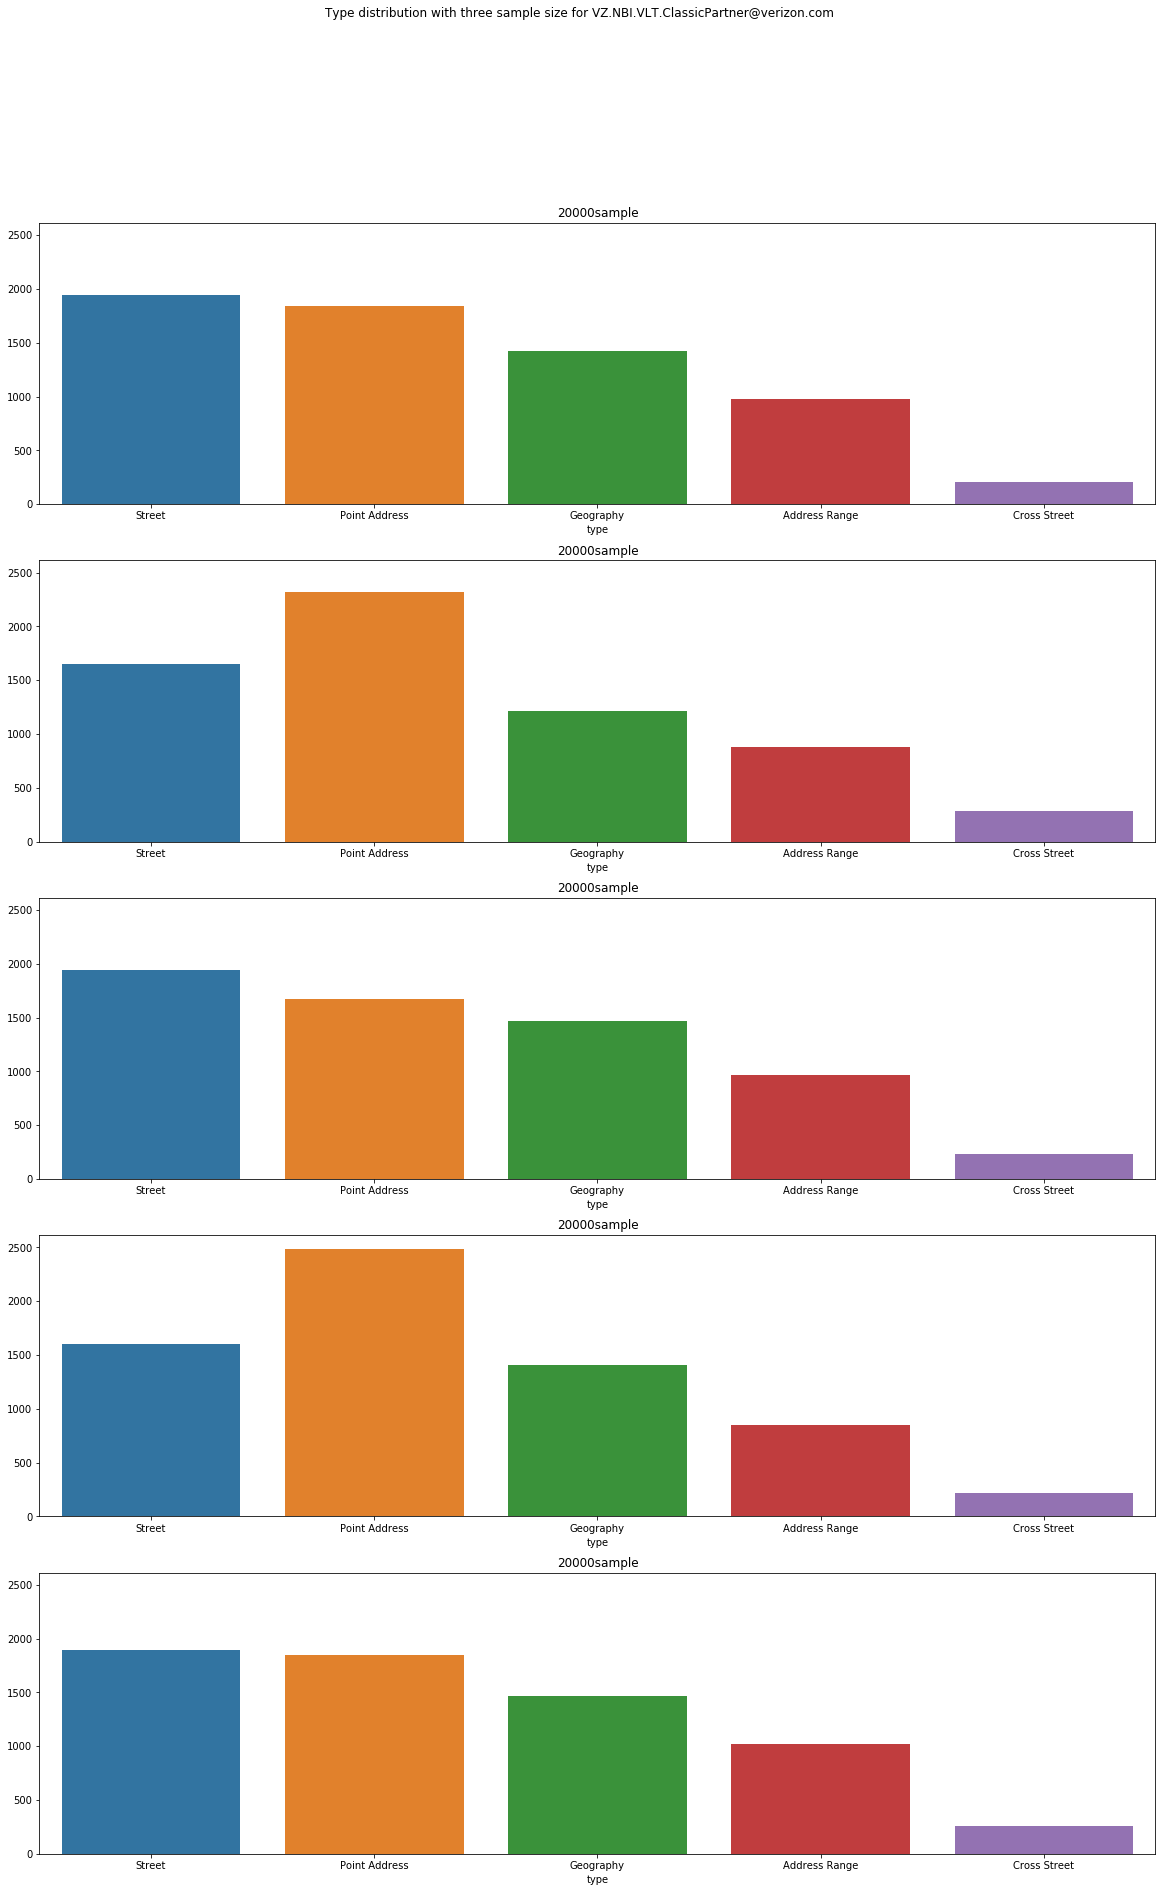

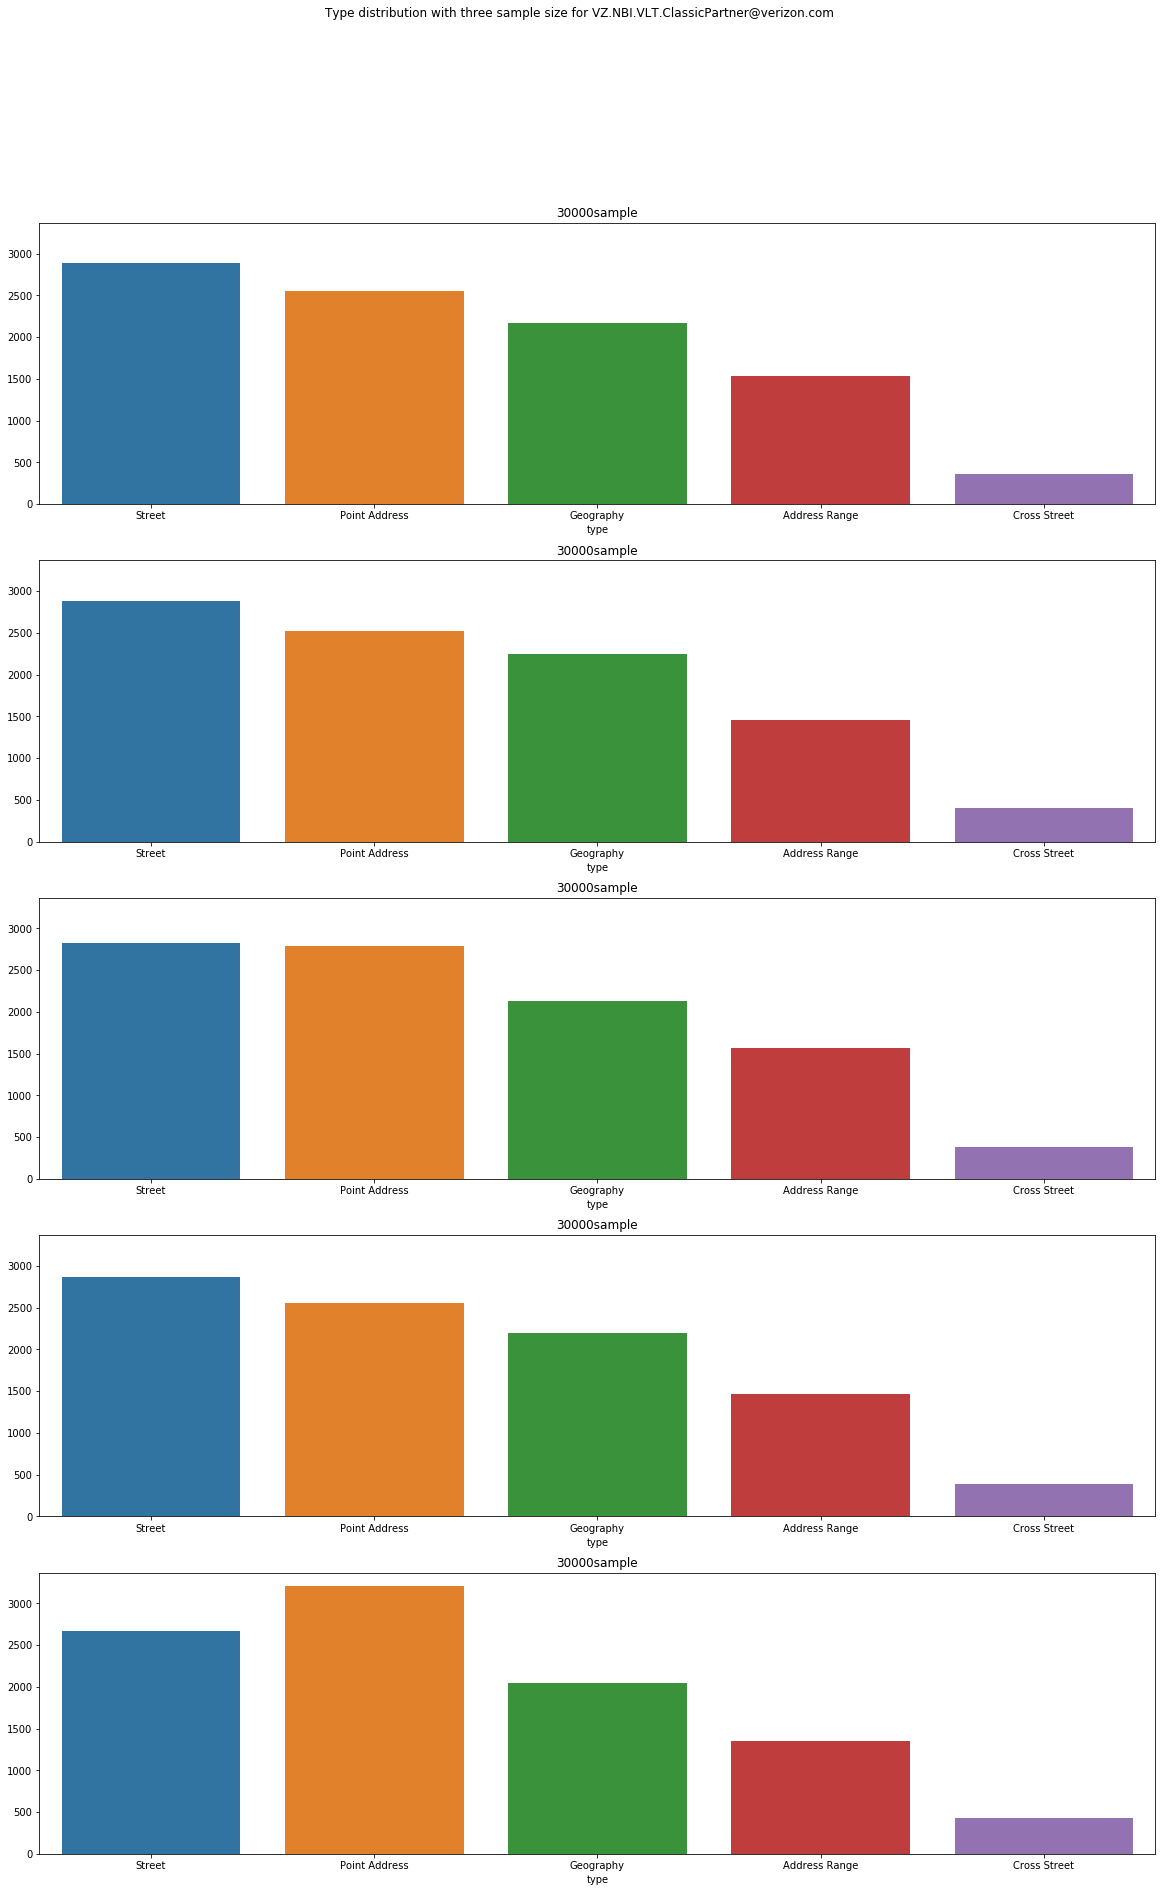

In [94]:
sample_type_customer("VZ.NBI.VLT.ClassicPartner@verizon.com", sample_size, n_df_samples)

# Add one more sample size: 40,000 samples

In [95]:
# Take more samples
take_sample(40000, n_days_samples, n_df_samples)

/Users/bakhtiar/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 1 out of 5
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 2 out of 5
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 3 out of 5
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 4 out of 5
5 clients out of 20
10 clients out of 20
15 clients out of 20
20 clients out of 20
Done with sample dataframe 5 out of 5
Done.


In [97]:
dct['lst_%s' % 40000] = [globals()['df_sample_'+str(40000)+'_'+str(i)].groupby(['countryCode']
                                                                                     ).count().sort_values(by='developer_email', ascending=False)['developer_email'] for i in range(5)]

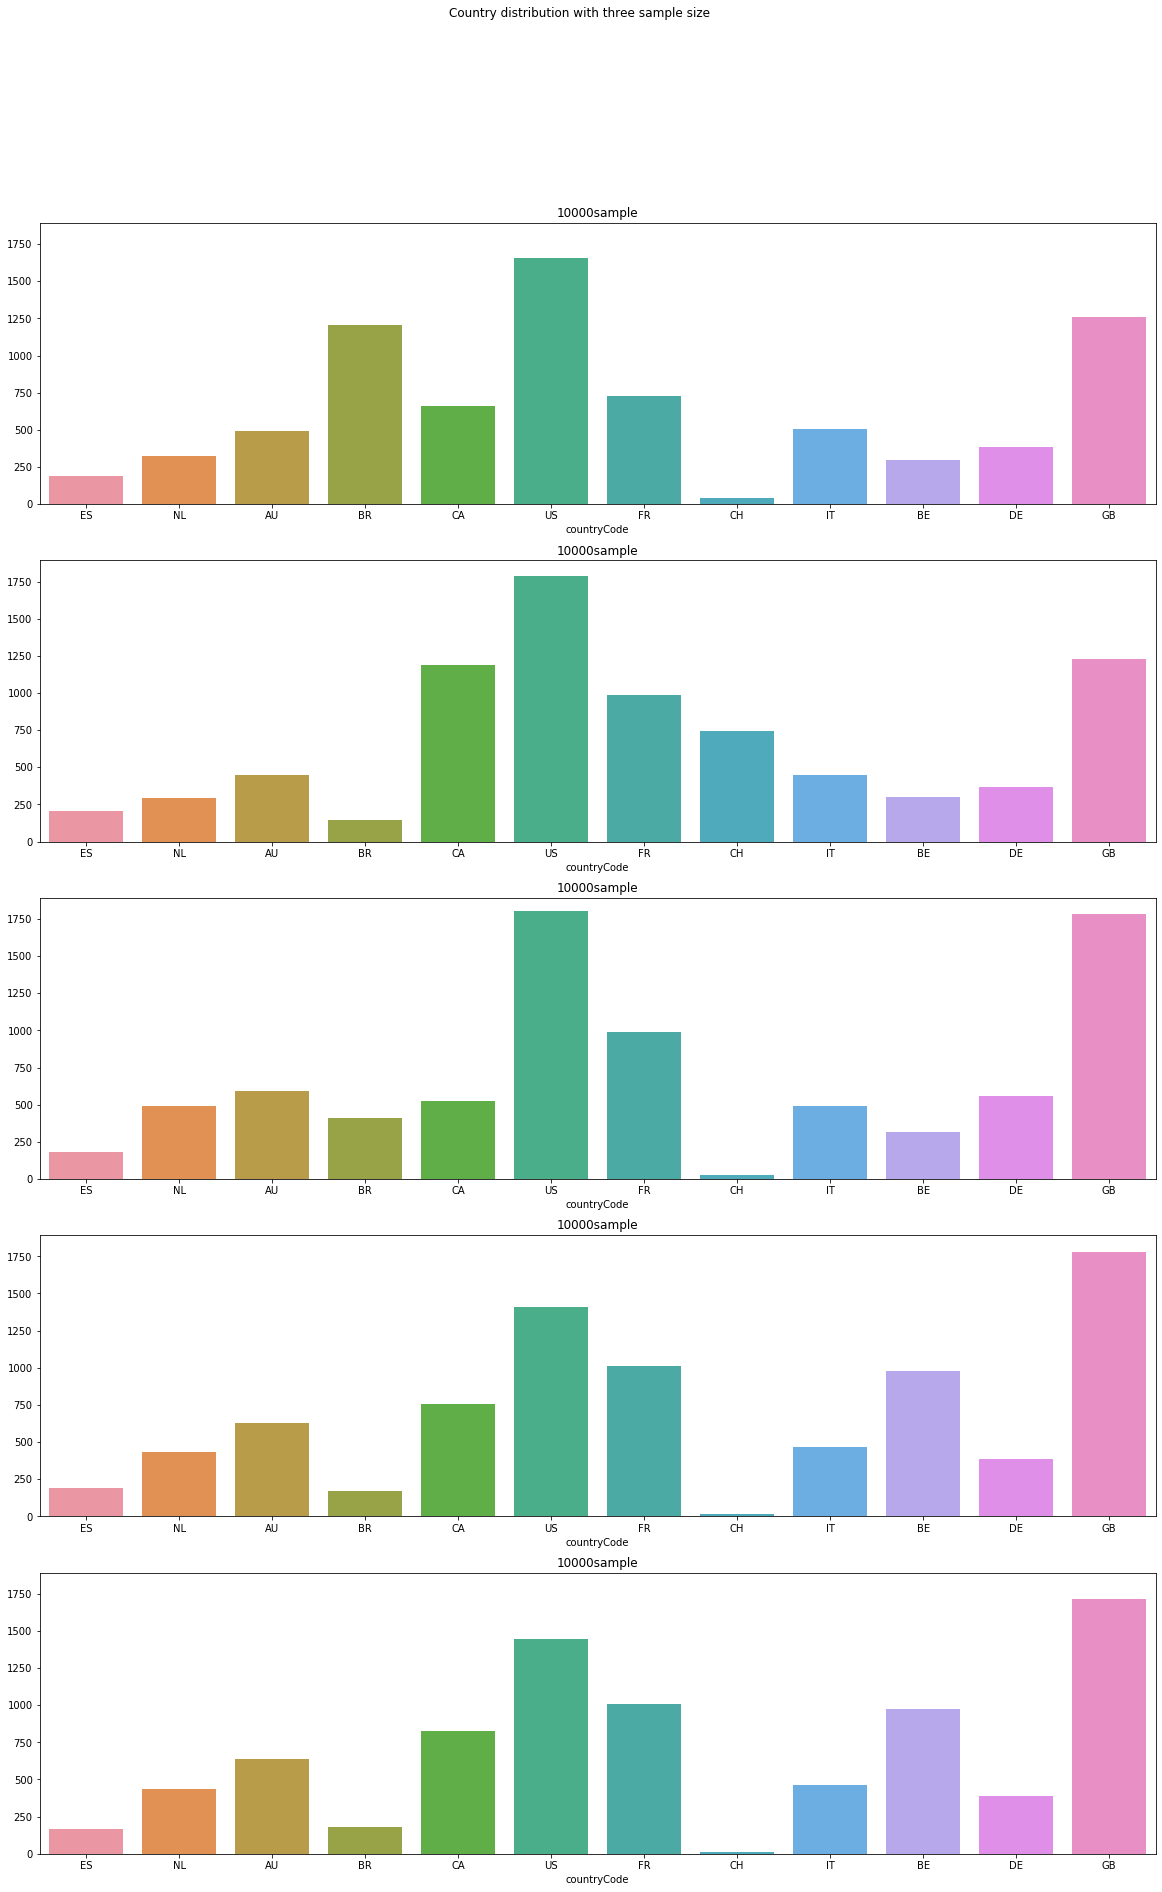

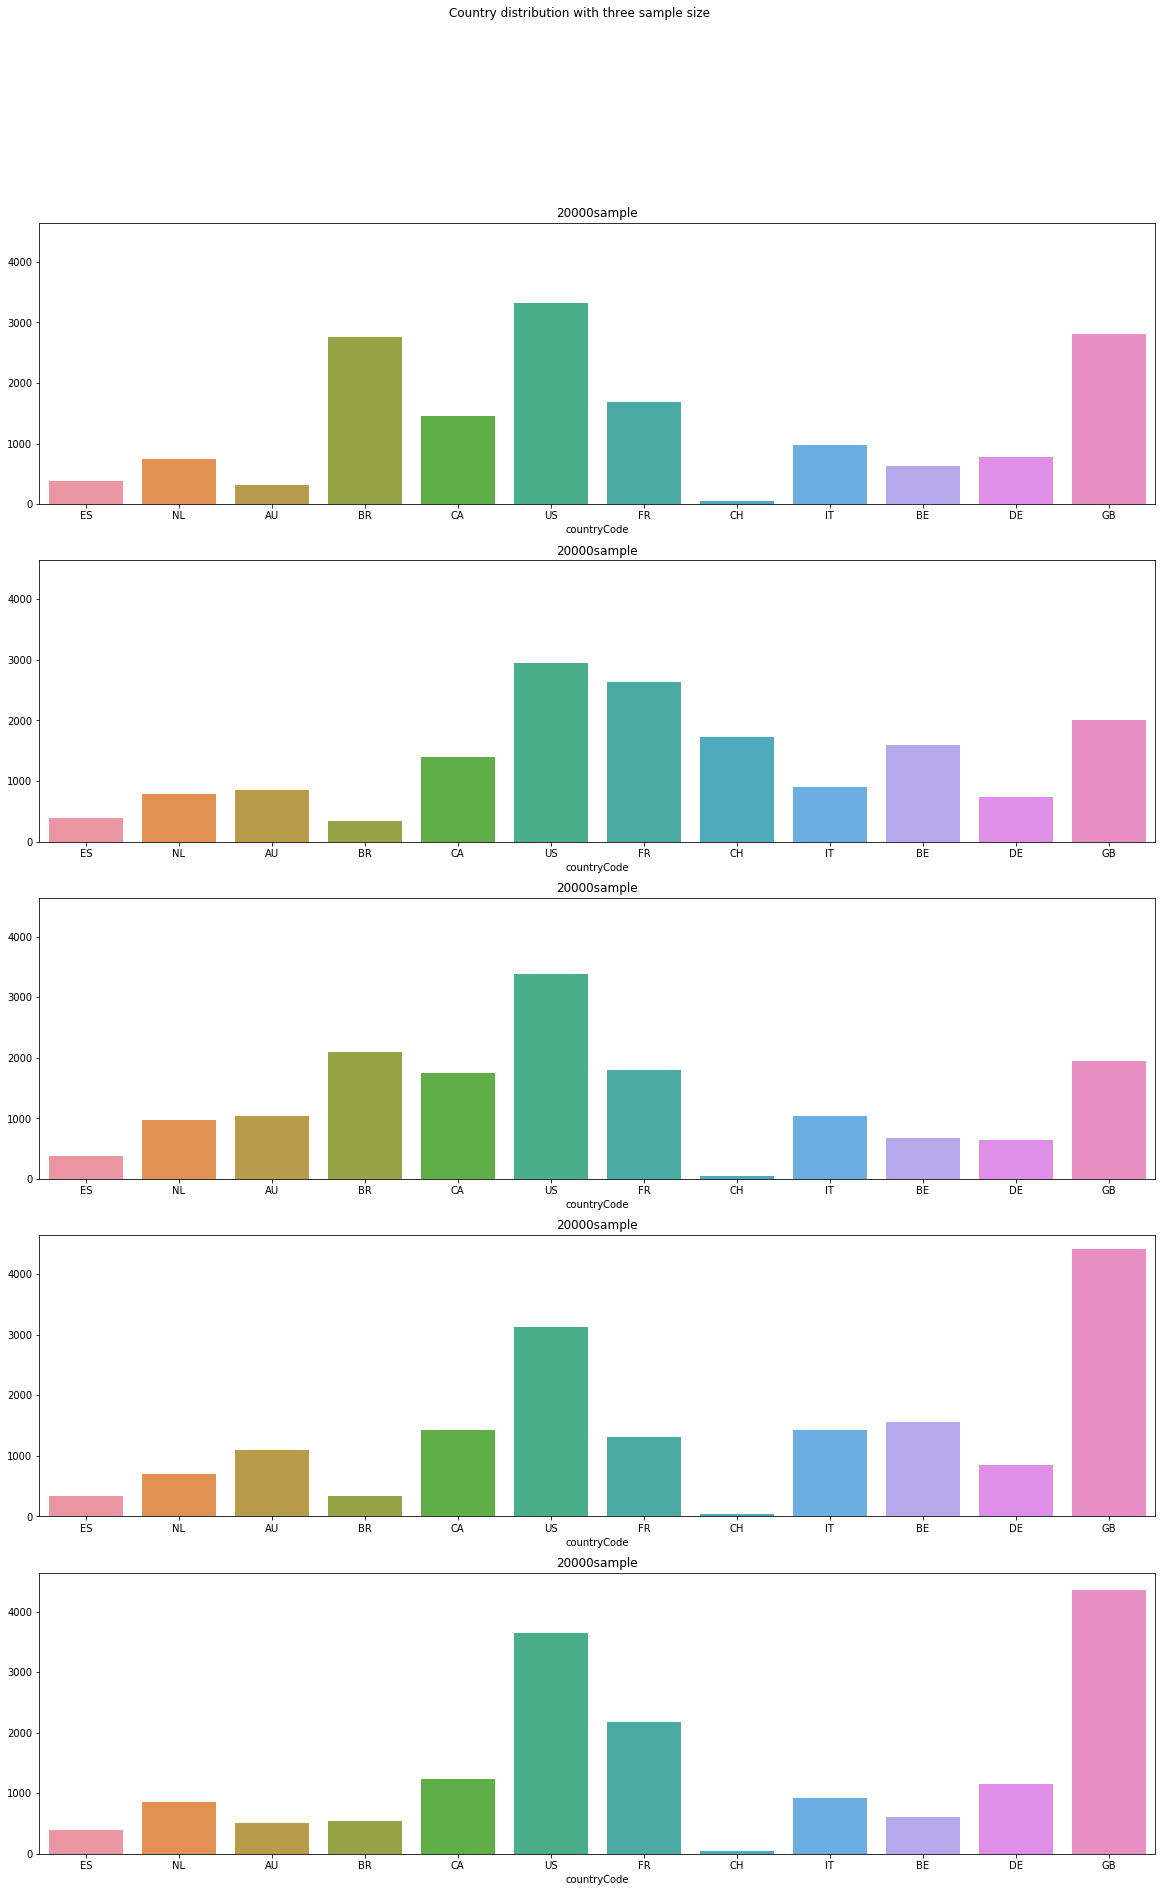

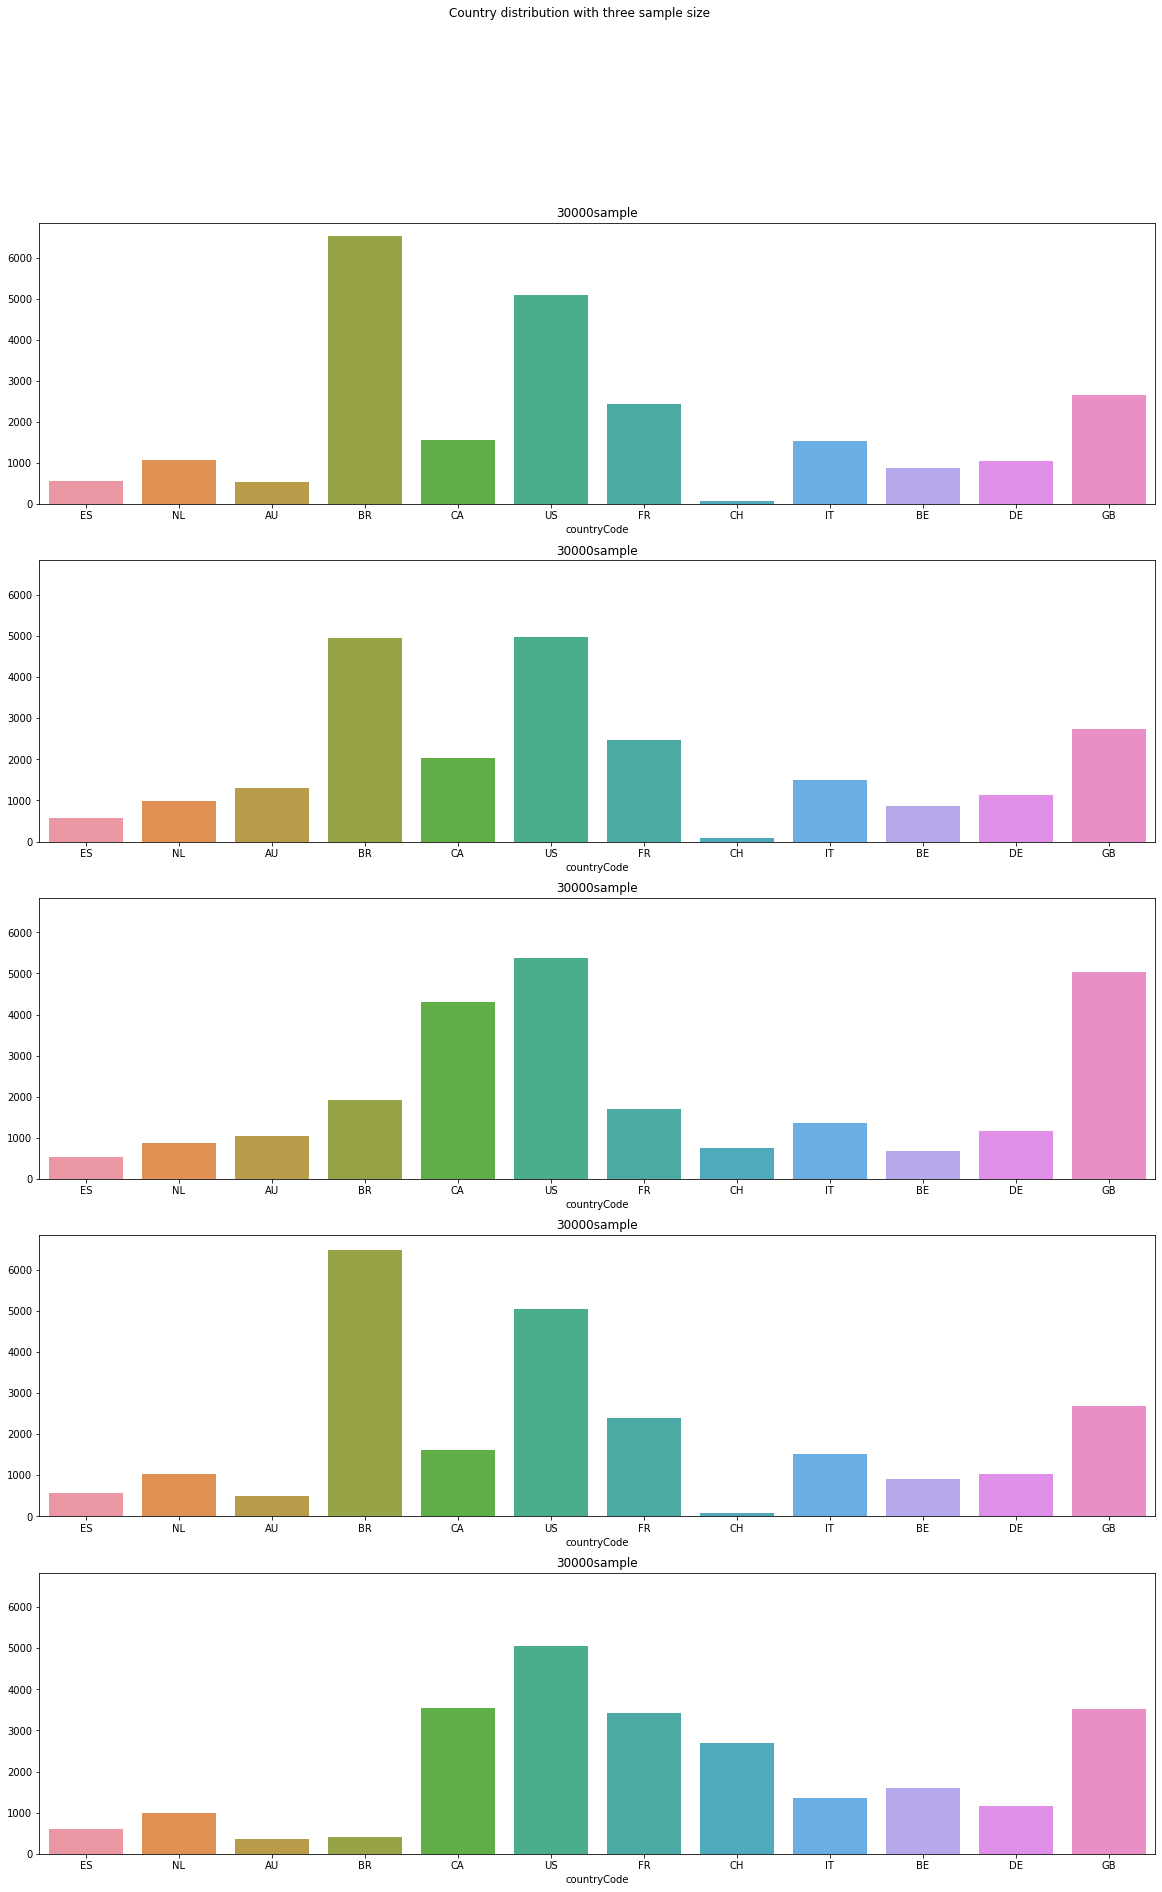

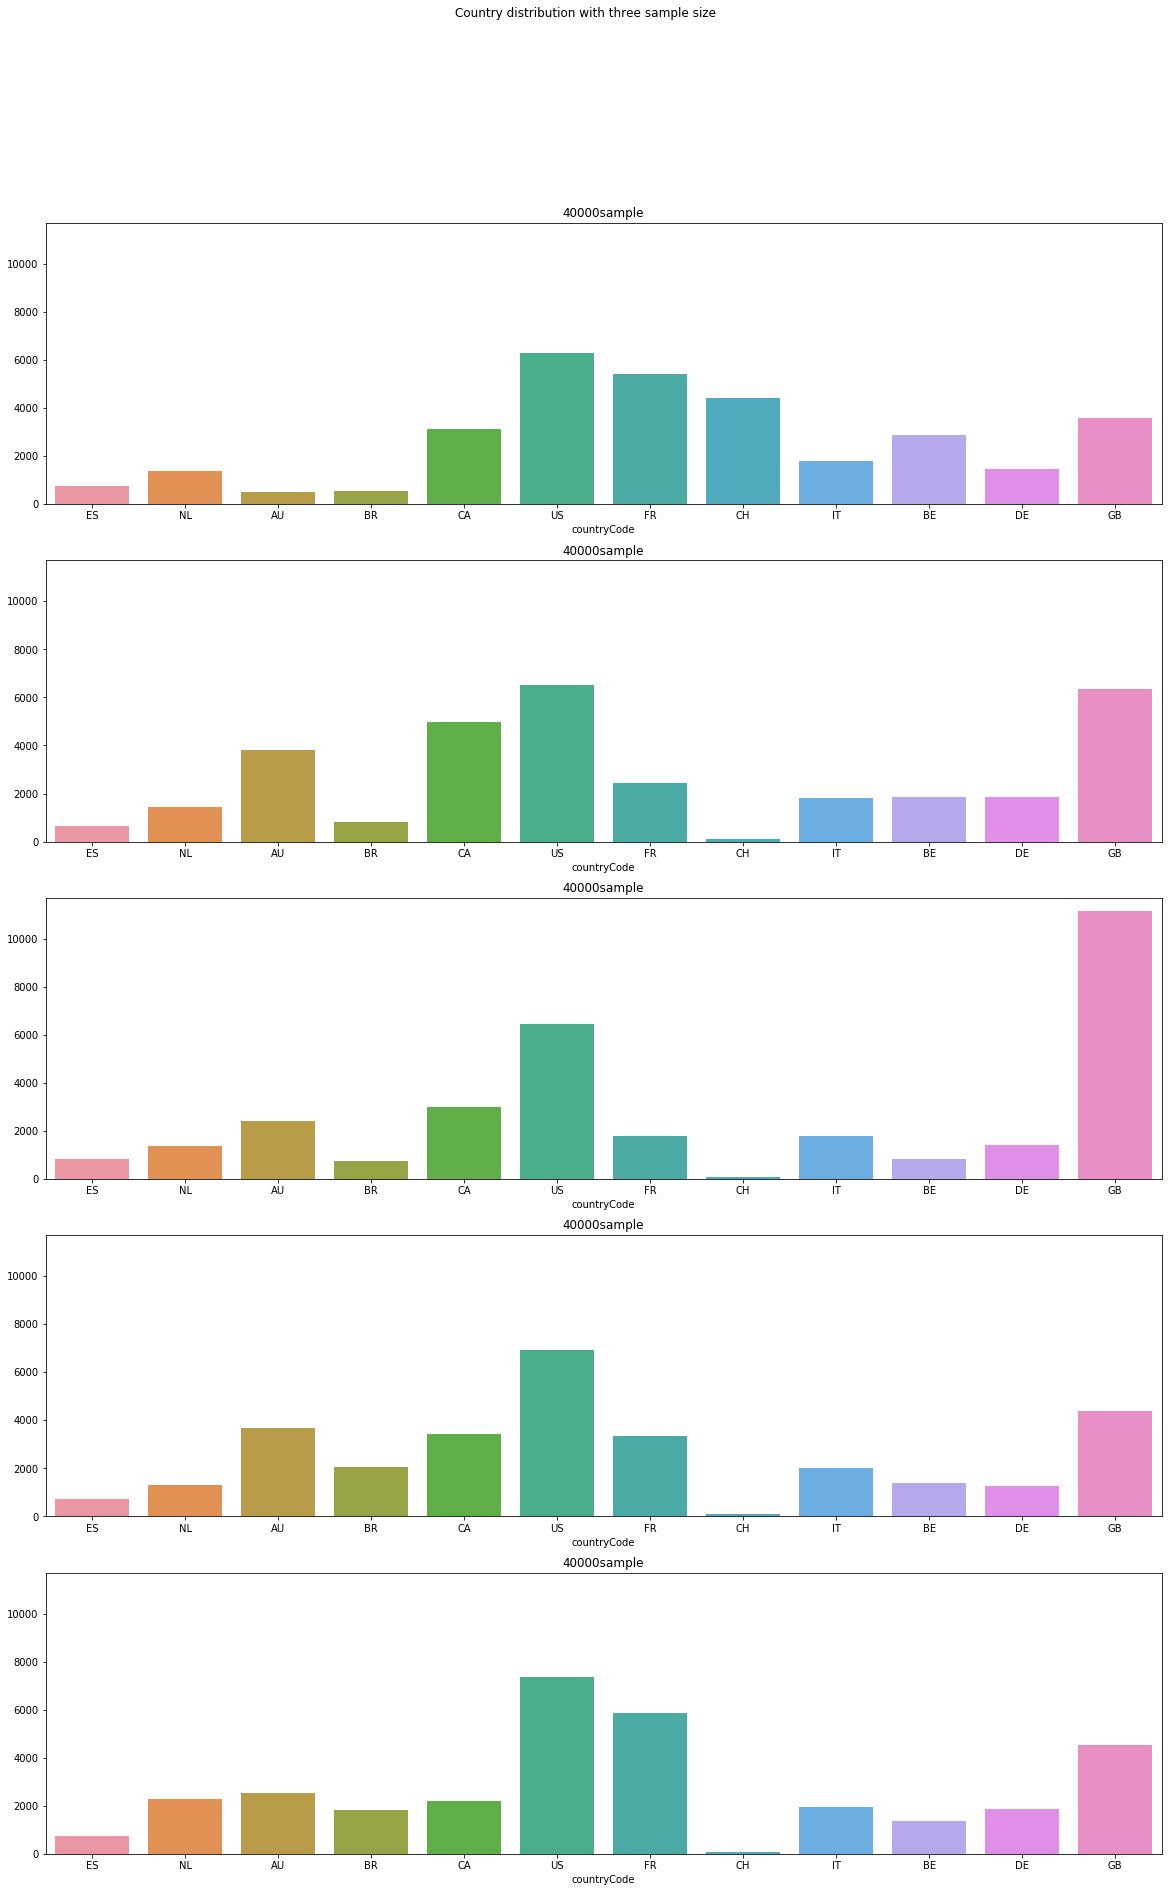

In [98]:
%matplotlib inline
for n in sample_size + [40000]:
    fig, axes = plt.subplots(5, 1, figsize=(20, 30), sharey=True)
    fig.suptitle('Country distribution with three sample size')
    for i in range(5):
        sns.barplot(ax=axes[i], x=dct['lst_%s' % n][i].filter(
            items=ls_countries, axis=0).index, y=dct['lst_%s' % n][i].filter(items=ls_countries, axis=0).values)
        axes[i].set_title(str(n) + 'sample')